In [1]:
import pandas as pd
import numpy as np
import talib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scs
import re
from datetime import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import recall_score, accuracy_score, precision_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import SGD
import theano
import xgboost as xgb
import gc


%matplotlib inline
plt.style.use('ggplot')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
plt.rcParams["figure.figsize"] = (12,12)
pd.options.display.max_columns = None
pd.set_option('display.float_format', lambda x: '%.6f' % x)

Using TensorFlow backend.
/home/applesauce/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [27]:
ls

forexeda.ipynb  oandadatapickledf.py  __pycache__/
models.py       oandadatapostgres.py


In [28]:
who

AdaBoostClassifier	 DecisionTreeClassifier	 Dense	 GradientBoostingClassifier	 GridSearchCV	 HTML	 KFold	 LogisticRegression	 MaxAbsScaler	 
MinMaxScaler	 PCA	 RandomForestClassifier	 RobustScaler	 SGD	 SVC	 Sequential	 StandardScaler	 TSNE	 
TimeSeriesSplit	 accuracy_score	 auc	 ax	 axes	 classification_report	 close_prices	 close_prices_scaled	 cross_val_score	 
datetime	 df	 df_columns	 display	 fig	 gc	 i	 ma	 make_pipeline	 
mm	 np	 np_utils	 pd	 plot_price	 plt	 precision_score	 re	 recall_score	 
roc_curve	 rs	 sc	 scale	 scalers	 scs	 sns	 talib	 theano	 
train_test_split	 up_down	 xgb	 


# Get Data

In [11]:
df = pd.read_pickle('../data/EUR_USD_M15')
df.set_index('time', inplace=True)
df.shape
df_columns = list(df.columns)

In [12]:
df[['volume', 'open', 'high', 'low', 'close', 'complete']].iloc[50:60]

,volume,open,high,low,close,complete
time,,,,,,
2005-01-03 06:45:00,473,1.346250,1.348050,1.345950,1.348050,True
2005-01-03 07:00:00,481,1.347950,1.348250,1.347350,1.348150,True
2005-01-03 07:15:00,303,1.348150,1.348350,1.347300,1.347900,True
2005-01-03 07:30:00,290,1.348000,1.350850,1.348000,1.350750,True
2005-01-03 07:45:00,373,1.350650,1.353250,1.350250,1.352800,True
2005-01-03 08:00:00,290,1.352800,1.354700,1.352500,1.352500,True
2005-01-03 08:15:00,219,1.352400,1.353000,1.351250,1.351570,True
2005-01-03 08:30:00,206,1.351670,1.351900,1.350470,1.351700,True
2005-01-03 08:45:00,186,1.351750,1.353270,1.351750,1.353070,True


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 321957 entries, 2005-01-02 18:15:00 to 2017-09-08 20:45:00
Data columns (total 6 columns):
volume      321957 non-null int64
close       321957 non-null float64
high        321957 non-null float64
low         321957 non-null float64
open        321957 non-null float64
complete    321957 non-null bool
dtypes: bool(1), float64(4), int64(1)
memory usage: 15.0 MB


In [14]:
def plot_price(price_series, figtitle):
    fig, ax = plt.subplots(figsize=(25,10))
    ax.plot(price_series)
    ax.set_title(figtitle)    

In [15]:
df = df.loc[datetime(2012,1,1):datetime(2018,1,1)]
df.shape

(142098, 6)

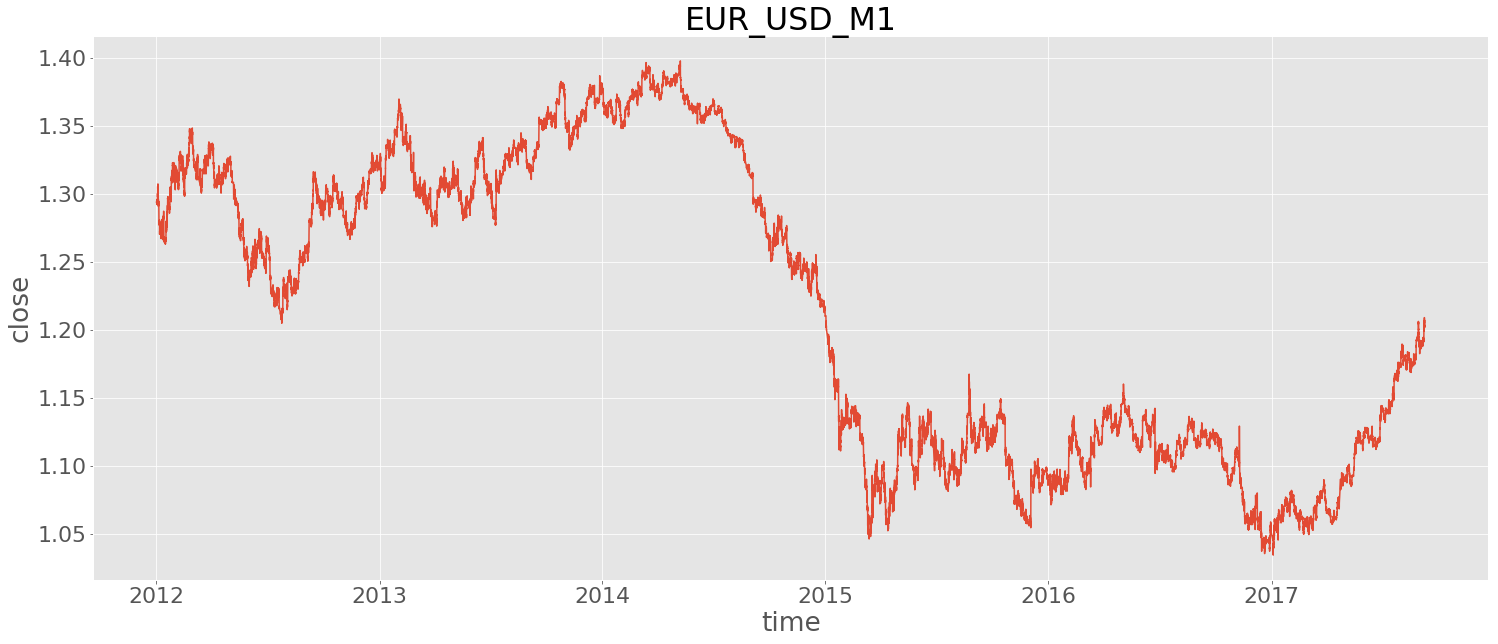

In [16]:
plt.rcParams.update({'font.size': 22})
plot_price(df['close'], 'EUR_USD_M1')
plt.xlabel('time')
plt.ylabel('close')

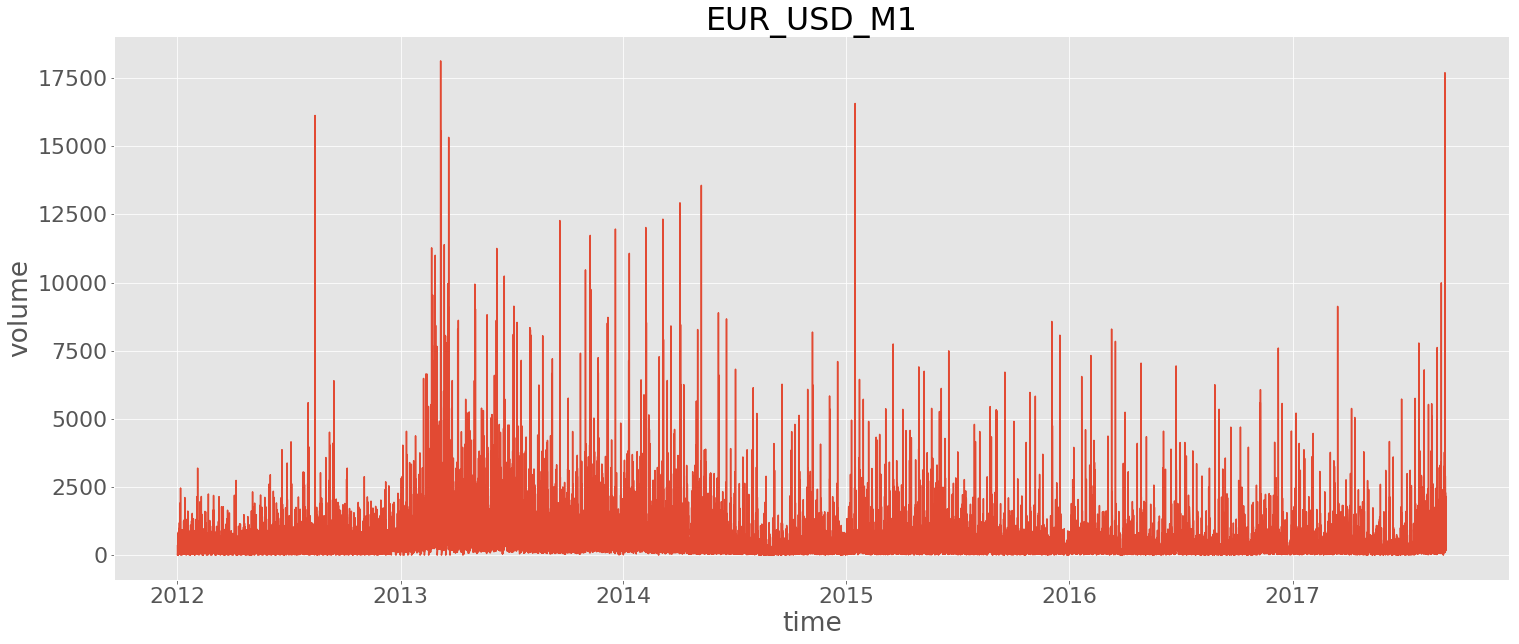

In [17]:
plot_price(df['volume'], 'EUR_USD_M1')
plt.xlabel('time')
plt.ylabel('volume')

In [18]:
close_prices = df['close'].values.reshape(-1,1)
close_prices.shape

(142098, 1)

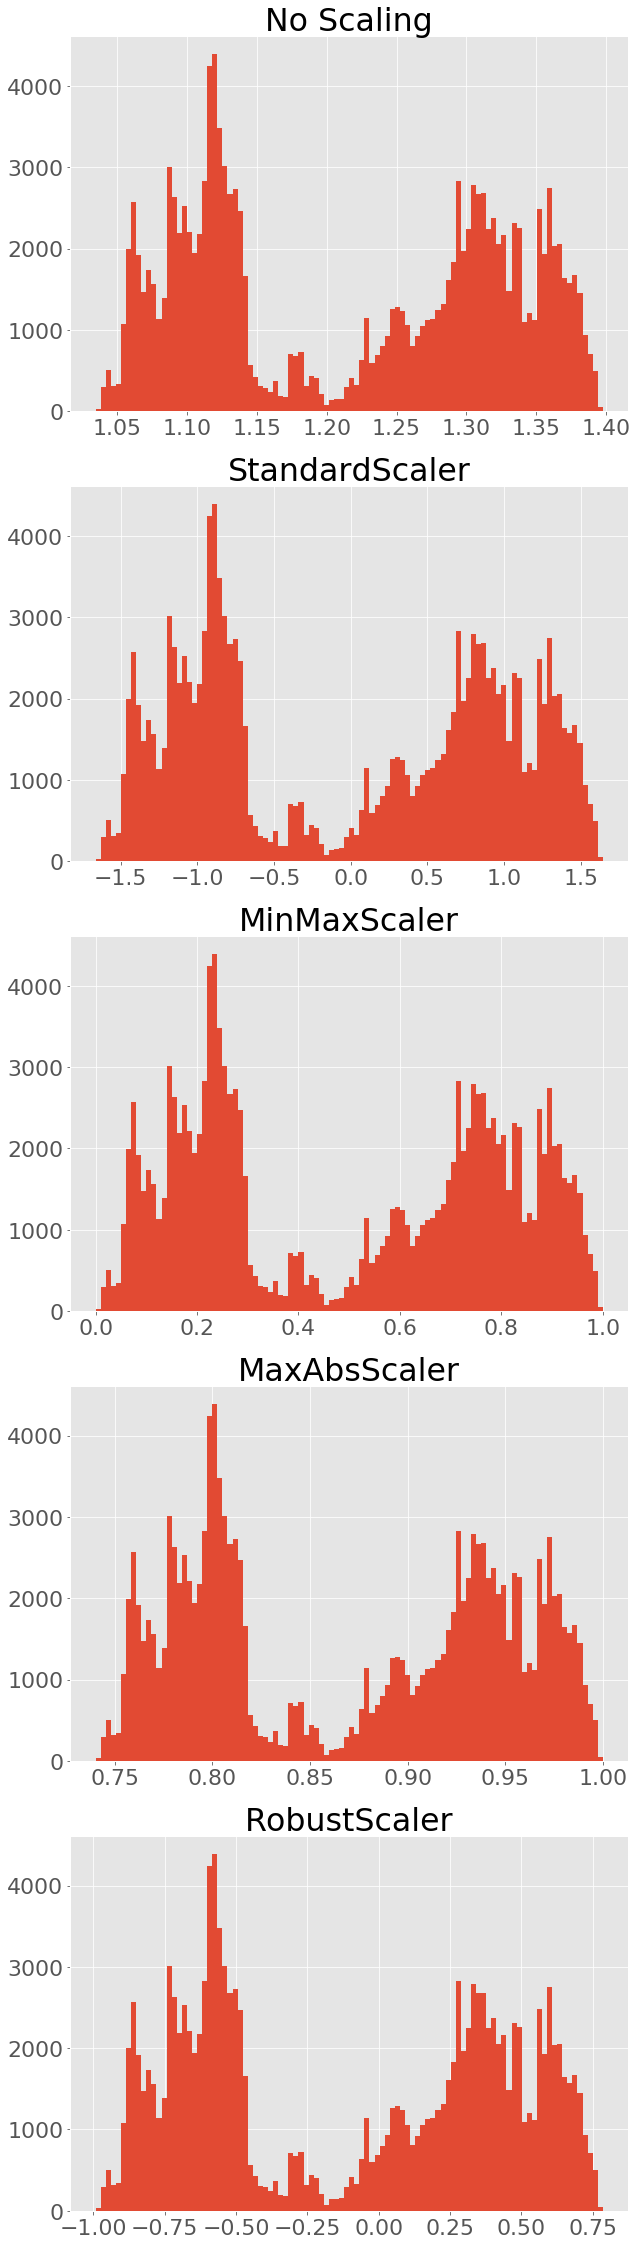

In [19]:
sc, mm, ma, rs = StandardScaler(), MinMaxScaler(), MaxAbsScaler(), RobustScaler()
scalers = [sc, mm, ma, rs]
fig, axes = plt.subplots(len(scalers)+1, 1, figsize=(10,40))
for i, ax in enumerate(axes.reshape(-1)):
    if i == 0:
        ax.hist(close_prices, bins=100)
        ax.set_title('No Scaling')
    else:
        scale = scalers[i-1]
        close_prices_scaled = scale.fit_transform(close_prices)
        ax.hist(close_prices_scaled, bins=100)
        ax.set_title(scale.__class__.__name__)

In [20]:
df_columns = list(df.columns)

# Add Target for Classification (Up / Down)

target of i day is the np.sign((open i+d) - (open i))

Exponentially smooth data before calculating features?

In [21]:
# df = pd.read_pickle('data/EUR_USD_H12')
# df.set_index('time', inplace=True)
# df.shape
# df.head()

In [22]:
def up_down(row):
    if row >= 0:
        return 1
    elif row < 0:
        return 0
    else:
        None

In [23]:
df['log_returns'] = np.log(df['close'] / df['close'].shift(1))
df['ari_returns'] = (df['close'] / df['close'].shift(1)) - 1
df['log_returns_shifted'] = np.log(df['close'].shift(-1) / df['close'])
df['target_label_direction'] = df['log_returns'].apply(up_down)
df['target_label_direction_shifted'] = df['log_returns_shifted'].apply(up_down)

In [24]:
df[['volume', 'open', 'high', 'low', 'close', 'complete', 'log_returns', 'log_returns_shifted', 'target_label_direction_shifted']].iloc[:10]

,volume,open,high,low,close,complete,log_returns,log_returns_shifted,target_label_direction_shifted
time,,,,,,,,,
2012-01-01 17:45:00,3,1.295250,1.295250,1.294160,1.294160,True,nan,-0.000703,0.000000
2012-01-01 18:00:00,369,1.294090,1.296120,1.291300,1.293250,True,-0.000703,0.000472,1.000000
2012-01-01 18:15:00,58,1.293190,1.294140,1.293060,1.293860,True,0.000472,-0.000093,0.000000
2012-01-01 18:30:00,80,1.293900,1.294450,1.293740,1.293740,True,-0.000093,-0.000077,0.000000
2012-01-01 18:45:00,21,1.293700,1.293750,1.293410,1.293640,True,-0.000077,-0.000286,0.000000
2012-01-01 19:00:00,16,1.293720,1.293720,1.293230,1.293270,True,-0.000286,0.000085,1.000000
2012-01-01 19:15:00,22,1.293310,1.293620,1.293150,1.293380,True,0.000085,-0.000101,0.000000
2012-01-01 19:30:00,3,1.293340,1.293340,1.293250,1.293250,True,-0.000101,0.000101,1.000000
2012-01-01 19:45:00,2,1.293310,1.293380,1.293310,1.293380,True,0.000101,-0.000077,0.000000


In [25]:
np.log(1.34455/1.35525)

-0.0079265545770773362

In [26]:
df.tail()

,volume,close,high,low,open,complete,log_returns,ari_returns,log_returns_shifted,target_label_direction,target_label_direction_shifted
time,,,,,,,,,,,
2017-09-08 19:45:00,423,1.202640,1.203450,1.202620,1.203320,True,-0.000565,-0.000565,0.000665,0.000000,1.000000
2017-09-08 20:00:00,164,1.203440,1.203480,1.202620,1.202620,True,0.000665,0.000665,0.000100,1.000000,1.000000
2017-09-08 20:15:00,161,1.203560,1.203600,1.203380,1.203460,True,0.000100,0.000100,-0.000017,1.000000,0.000000
2017-09-08 20:30:00,297,1.203540,1.203840,1.203480,1.203500,True,-0.000017,-0.000017,-0.000008,0.000000,0.000000
2017-09-08 20:45:00,547,1.203530,1.203820,1.202840,1.203560,True,-0.000008,-0.000008,nan,0.000000,nan


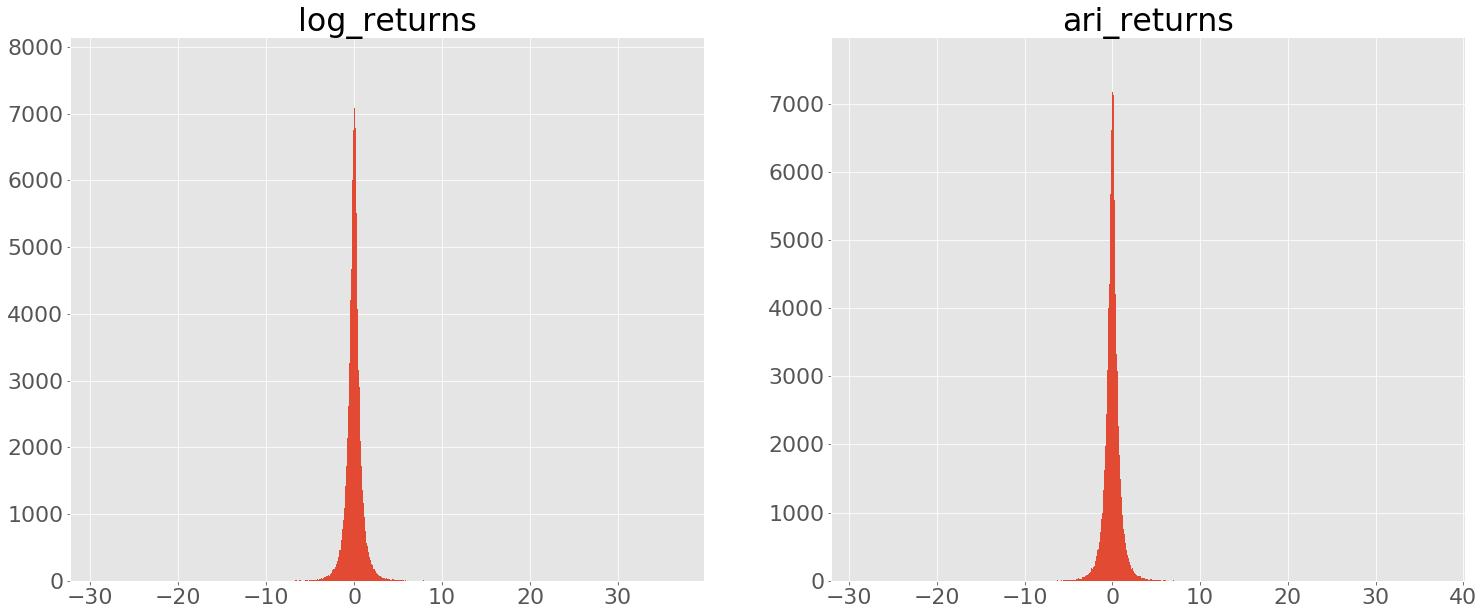

In [27]:
return_types = ['log_returns', 'ari_returns']
fig, axes = plt.subplots(1, len(return_types), figsize=(25,10))
for i, ax in enumerate(axes.reshape(-1)):
    returns = df[return_types[i]].dropna().values.reshape(-1,1)
    returns = StandardScaler().fit_transform(returns)
    ax.hist(returns, bins=1000)
    ax.set_title(return_types[i])
plt.show()

# Scale

In [28]:
df.describe()

,volume,close,high,low,open,log_returns,ari_returns,log_returns_shifted,target_label_direction,target_label_direction_shifted
count,142098.000000,142098.000000,142098.000000,142098.000000,142098.000000,142097.000000,142097.000000,142097.000000,142097.000000,142097.000000
mean,478.268357,1.217206,1.217627,1.216793,1.217206,-0.000001,-0.000000,-0.000001,0.508850,0.508850
std,619.661775,0.109855,0.109829,0.109881,0.109855,0.000565,0.000565,0.000565,0.499923,0.499923
min,1.000000,1.034540,1.036290,1.034060,1.034500,-0.016387,-0.016253,-0.016387,0.000000,0.000000
25%,147.000000,1.114080,1.114502,1.113690,1.114080,-0.000221,-0.000221,-0.000221,0.000000,0.000000
50%,302.000000,1.237290,1.237730,1.236830,1.237280,0.000000,0.000000,0.000000,1.000000,1.000000
75%,580.000000,1.318360,1.318720,1.317930,1.318360,0.000220,0.000220,0.000220,1.000000,1.000000
max,18129.000000,1.397680,1.399360,1.395310,1.397640,0.020652,0.020867,0.020652,1.000000,1.000000


In [29]:
df.drop('complete', axis=1, inplace=True)

In [30]:
# scale_columns = ['volume', 'close', 'high', 'low', 'open',]
# mm = MinMaxScaler()
# scale_values = mm.fit_transform(df[scale_columns])
# df[scale_columns] = scale_values
# df.describe()

In [31]:
df.head()

,volume,close,high,low,open,log_returns,ari_returns,log_returns_shifted,target_label_direction,target_label_direction_shifted
time,,,,,,,,,,
2012-01-01 17:45:00,3,1.294160,1.295250,1.294160,1.295250,nan,nan,-0.000703,nan,0.000000
2012-01-01 18:00:00,369,1.293250,1.296120,1.291300,1.294090,-0.000703,-0.000703,0.000472,0.000000,1.000000
2012-01-01 18:15:00,58,1.293860,1.294140,1.293060,1.293190,0.000472,0.000472,-0.000093,1.000000,0.000000
2012-01-01 18:30:00,80,1.293740,1.294450,1.293740,1.293900,-0.000093,-0.000093,-0.000077,0.000000,0.000000
2012-01-01 18:45:00,21,1.293640,1.293750,1.293410,1.293700,-0.000077,-0.000077,-0.000286,0.000000,0.000000


# Add Features pandas

In [32]:
# df['20d_ma'] = df['close'].rolling(window=20).mean()
# df['50d_ma'] = df['close'].rolling(window=50).mean()
# df['Bol_upper'] = df['close'].rolling(window=20).mean() + 2* df['close'].rolling(window=20, min_periods=20).std()
# df['Bol_lower'] = df['close'].rolling(window=20).mean() - 2* df['close'].rolling(window=20, min_periods=20).std()
# df['Bol_BW'] = ((df['Bol_upper'] - df['Bol_lower'])/df['20d_ma'])*100
# df['Bol_BW_200MA'] = df['Bol_BW'].rolling(window=50).mean()
# df['20d_exma'] = df['close'].ewm(span=20).mean()
# df['50d_exma'] = df['close'].ewm(span=50).mean()

In [33]:
# df.plot(y=['close','20d_ma','50d_ma','Bol_upper','Bol_lower'], figsize=(25,10))

In [34]:
# df.plot(y=['close', '20d_exma','50d_exma'], figsize=(25,10))

In [35]:
# df.plot(y=['Bol_BW','Bol_BW_200MA'], figsize=(25,10))

# Add Features TA-Lib

In [36]:
print(talib.get_function_groups().keys())
print(talib.get_functions())
#talib.abstract.__all__

dict_keys(['Cycle Indicators', 'Math Operators', 'Math Transform', 'Momentum Indicators', 'Overlap Studies', 'Pattern Recognition', 'Price Transform', 'Statistic Functions', 'Volatility Indicators', 'Volume Indicators'])
['HT_DCPERIOD', 'HT_DCPHASE', 'HT_PHASOR', 'HT_SINE', 'HT_TRENDMODE', 'ADD', 'DIV', 'MAX', 'MAXINDEX', 'MIN', 'MININDEX', 'MINMAX', 'MINMAXINDEX', 'MULT', 'SUB', 'SUM', 'ACOS', 'ASIN', 'ATAN', 'CEIL', 'COS', 'COSH', 'EXP', 'FLOOR', 'LN', 'LOG10', 'SIN', 'SINH', 'SQRT', 'TAN', 'TANH', 'ADX', 'ADXR', 'APO', 'AROON', 'AROONOSC', 'BOP', 'CCI', 'CMO', 'DX', 'MACD', 'MACDEXT', 'MACDFIX', 'MFI', 'MINUS_DI', 'MINUS_DM', 'MOM', 'PLUS_DI', 'PLUS_DM', 'PPO', 'ROC', 'ROCP', 'ROCR', 'ROCR100', 'RSI', 'STOCH', 'STOCHF', 'STOCHRSI', 'TRIX', 'ULTOSC', 'WILLR', 'BBANDS', 'DEMA', 'EMA', 'HT_TRENDLINE', 'KAMA', 'MA', 'MAMA', 'MAVP', 'MIDPOINT', 'MIDPRICE', 'SAR', 'SAREXT', 'SMA', 'T3', 'TEMA', 'TRIMA', 'WMA', 'CDL2CROWS', 'CDL3BLACKCROWS', 'CDL3INSIDE', 'CDL3LINESTRIKE', 'CDL3OUTSIDE', '

In [37]:
mom_ind = talib.get_function_groups()['Momentum Indicators']
over_stud = talib.get_function_groups()['Overlap Studies']
volu_ind = talib.get_function_groups()['Volume Indicators']
cyc_ind = talib.get_function_groups()['Cycle Indicators']
vola_ind = talib.get_function_groups()['Volatility Indicators']
stats_ind = talib.get_function_groups()['Statistic Functions']
talib_abstract_fun_list = mom_ind + over_stud + volu_ind + cyc_ind + vola_ind + stats_ind
# talib_abstract_fun_list = talib.abstract.__all__[1:]
# talib_abstract_fun_list = ['RSI', 'STOCH', 'WILLR', 'ATR', 'MACD']
print(talib_abstract_fun_list)

['ADX', 'ADXR', 'APO', 'AROON', 'AROONOSC', 'BOP', 'CCI', 'CMO', 'DX', 'MACD', 'MACDEXT', 'MACDFIX', 'MFI', 'MINUS_DI', 'MINUS_DM', 'MOM', 'PLUS_DI', 'PLUS_DM', 'PPO', 'ROC', 'ROCP', 'ROCR', 'ROCR100', 'RSI', 'STOCH', 'STOCHF', 'STOCHRSI', 'TRIX', 'ULTOSC', 'WILLR', 'BBANDS', 'DEMA', 'EMA', 'HT_TRENDLINE', 'KAMA', 'MA', 'MAMA', 'MAVP', 'MIDPOINT', 'MIDPRICE', 'SAR', 'SAREXT', 'SMA', 'T3', 'TEMA', 'TRIMA', 'WMA', 'AD', 'ADOSC', 'OBV', 'HT_DCPERIOD', 'HT_DCPHASE', 'HT_PHASOR', 'HT_SINE', 'HT_TRENDMODE', 'ATR', 'NATR', 'TRANGE', 'BETA', 'CORREL', 'LINEARREG', 'LINEARREG_ANGLE', 'LINEARREG_INTERCEPT', 'LINEARREG_SLOPE', 'STDDEV', 'TSF', 'VAR']


In [38]:
#talib_abstract_fun_list = [i for i in talib_abstract_fun_list if i not in ['MAVP','ASIN', 'ACOS']]
print(len(talib_abstract_fun_list))

67


In [39]:
print(talib_abstract_fun_list)

['ADX', 'ADXR', 'APO', 'AROON', 'AROONOSC', 'BOP', 'CCI', 'CMO', 'DX', 'MACD', 'MACDEXT', 'MACDFIX', 'MFI', 'MINUS_DI', 'MINUS_DM', 'MOM', 'PLUS_DI', 'PLUS_DM', 'PPO', 'ROC', 'ROCP', 'ROCR', 'ROCR100', 'RSI', 'STOCH', 'STOCHF', 'STOCHRSI', 'TRIX', 'ULTOSC', 'WILLR', 'BBANDS', 'DEMA', 'EMA', 'HT_TRENDLINE', 'KAMA', 'MA', 'MAMA', 'MAVP', 'MIDPOINT', 'MIDPRICE', 'SAR', 'SAREXT', 'SMA', 'T3', 'TEMA', 'TRIMA', 'WMA', 'AD', 'ADOSC', 'OBV', 'HT_DCPERIOD', 'HT_DCPHASE', 'HT_PHASOR', 'HT_SINE', 'HT_TRENDMODE', 'ATR', 'NATR', 'TRANGE', 'BETA', 'CORREL', 'LINEARREG', 'LINEARREG_ANGLE', 'LINEARREG_INTERCEPT', 'LINEARREG_SLOPE', 'STDDEV', 'TSF', 'VAR']


In [40]:
talib.abstract.MAVP.info

{'display_name': 'Moving average with variable period',
 'function_flags': ['Output scale same as input'],
 'group': 'Overlap Studies',
 'input_names': OrderedDict([('price', 'close'), ('periods', 'periods')]),
 'name': 'MAVP',
 'output_flags': OrderedDict([('real', ['Line'])]),
 'output_names': ['real'],
 'parameters': OrderedDict([('minperiod', 2),
              ('maxperiod', 30),
              ('matype', 0)])}

In [41]:
mom_ind = talib.get_function_groups()['Momentum Indicators']
over_stud = talib.get_function_groups()['Overlap Studies']
volu_ind = talib.get_function_groups()['Volume Indicators']
cyc_ind = talib.get_function_groups()['Cycle Indicators']
vola_ind = talib.get_function_groups()['Volatility Indicators']
stats_ind = talib.get_function_groups()['Statistic Functions']
talib_abstract_fun_list = mom_ind + over_stud + volu_ind + cyc_ind + vola_ind + stats_ind
talib_abstract_fun_list.remove('MAVP')
no_params_df = pd.DataFrame([])
only_time_period_df = pd.DataFrame([])
other_param_df = pd.DataFrame([])
for fun in talib_abstract_fun_list:
    info = getattr(talib.abstract, fun).info
    data = pd.Series([info['group'], info['name'], info['display_name'], ['{}: {}'.format(key, value) for key, value in info['parameters'].items()], info['output_names']])
    if len(info['parameters']) == 0:
        no_params_df = no_params_df.append(data, ignore_index=True)
    elif 'timeperiod' in info['parameters'] and len(info['parameters']) == 1:
        only_time_period_df = only_time_period_df.append(data, ignore_index=True)
    else:
        other_param_df = other_param_df.append(data, ignore_index=True)
ind_dfs = [no_params_df, only_time_period_df, other_param_df]
for ind_df in ind_dfs:
    ind_df.columns = ['Group', 'Name', 'Short Description', 'Parameters', 'Output Names']

In [42]:
talib.get_function_groups()['Overlap Studies']

['BBANDS',
 'DEMA',
 'EMA',
 'HT_TRENDLINE',
 'KAMA',
 'MA',
 'MAMA',
 'MAVP',
 'MIDPOINT',
 'MIDPRICE',
 'SAR',
 'SAREXT',
 'SMA',
 'T3',
 'TEMA',
 'TRIMA',
 'WMA']

In [43]:
no_params_df

,Group,Name,Short Description,Parameters,Output Names
0,Momentum Indicators,BOP,Balance Of Power,[],[real]
1,Overlap Studies,HT_TRENDLINE,Hilbert Transform - Instantaneous Trendline,[],[real]
2,Volume Indicators,AD,Chaikin A/D Line,[],[real]
3,Volume Indicators,OBV,On Balance Volume,[],[real]
4,Cycle Indicators,HT_DCPERIOD,Hilbert Transform - Dominant Cycle Period,[],[real]
5,Cycle Indicators,HT_DCPHASE,Hilbert Transform - Dominant Cycle Phase,[],[real]
6,Cycle Indicators,HT_PHASOR,Hilbert Transform - Phasor Components,[],"[inphase, quadrature]"
7,Cycle Indicators,HT_SINE,Hilbert Transform - SineWave,[],"[sine, leadsine]"
8,Cycle Indicators,HT_TRENDMODE,Hilbert Transform - Trend vs Cycle Mode,[],[integer]
9,Volatility Indicators,TRANGE,True Range,[],[real]


In [44]:
only_time_period_df

,Group,Name,Short Description,Parameters,Output Names
0,Momentum Indicators,ADX,Average Directional Movement Index,[timeperiod: 14],[real]
1,Momentum Indicators,ADXR,Average Directional Movement Index Rating,[timeperiod: 14],[real]
2,Momentum Indicators,AROON,Aroon,[timeperiod: 14],"[aroondown, aroonup]"
3,Momentum Indicators,AROONOSC,Aroon Oscillator,[timeperiod: 14],[real]
4,Momentum Indicators,CCI,Commodity Channel Index,[timeperiod: 14],[real]
5,Momentum Indicators,CMO,Chande Momentum Oscillator,[timeperiod: 14],[real]
6,Momentum Indicators,DX,Directional Movement Index,[timeperiod: 14],[real]
7,Momentum Indicators,MFI,Money Flow Index,[timeperiod: 14],[real]
8,Momentum Indicators,MINUS_DI,Minus Directional Indicator,[timeperiod: 14],[real]
9,Momentum Indicators,MINUS_DM,Minus Directional Movement,[timeperiod: 14],[real]


In [45]:
other_param_df
other_param_df.style.set_properties(subset=['Parameters'], **{'width': '600px'})

,Group,Name,Short Description,Parameters,Output Names
0,Momentum Indicators,APO,Absolute Price Oscillator,"['fastperiod: 12', 'slowperiod: 26', 'matype: 0']",['real']
1,Momentum Indicators,MACD,Moving Average Convergence/Divergence,"['fastperiod: 12', 'slowperiod: 26', 'signalperiod: 9']","['macd', 'macdsignal', 'macdhist']"
2,Momentum Indicators,MACDEXT,MACD with controllable MA type,"['fastperiod: 12', 'fastmatype: 0', 'slowperiod: 26', 'slowmatype: 0', 'signalperiod: 9', 'signalmatype: 0']","['macd', 'macdsignal', 'macdhist']"
3,Momentum Indicators,MACDFIX,Moving Average Convergence/Divergence Fix 12/26,['signalperiod: 9'],"['macd', 'macdsignal', 'macdhist']"
4,Momentum Indicators,PPO,Percentage Price Oscillator,"['fastperiod: 12', 'slowperiod: 26', 'matype: 0']",['real']
5,Momentum Indicators,STOCH,Stochastic,"['fastk_period: 5', 'slowk_period: 3', 'slowk_matype: 0', 'slowd_period: 3', 'slowd_matype: 0']","['slowk', 'slowd']"
6,Momentum Indicators,STOCHF,Stochastic Fast,"['fastk_period: 5', 'fastd_period: 3', 'fastd_matype: 0']","['fastk', 'fastd']"
7,Momentum Indicators,STOCHRSI,Stochastic Relative Strength Index,"['timeperiod: 14', 'fastk_period: 5', 'fastd_period: 3', 'fastd_matype: 0']","['fastk', 'fastd']"
8,Momentum Indicators,ULTOSC,Ultimate Oscillator,"['timeperiod1: 7', 'timeperiod2: 14', 'timeperiod3: 28']",['real']
9,Overlap Studies,BBANDS,Bollinger Bands,"['timeperiod: 5', 'nbdevup: 2', 'nbdevdn: 2', 'matype: 0']","['upperband', 'middleband', 'lowerband']"


In [46]:
ohlcv = {
    'open': df['open'],
    'high': df['high'],
    'low': df['low'],
    'close': df['close'],
    'volume': df['volume'].astype(float)
}

In [70]:
no_params_df[no_params_df['Name']=='HT_PHASOR']['Output Names'].values[0][0].upper()

'INPHASE'

In [68]:
ohlcv = {
    'open': df['open'],
    'high': df['high'],
    'low': df['low'],
    'close': df['close'],
    'volume': df['volume'].astype(float)
    }
for fun in no_params_df['Name'].values:
    res = getattr(talib.abstract, fun)(ohlcv)
    output = no_params_df[no_params_df['Name']==fun]['Output Names'].values[0]
    if len(output) == 1:
        df[fun+'_'+output[0].upper()] = res
    else:
        for i, val in enumerate(res):
            df[fun+'_'+output[i].upper()] = val
for fun in only_time_period_df['Name'].values:
    output = only_time_period_df[only_time_period_df['Name']==fun]['Output Names'].values[0]
    for timeperiod in range(5, 55, 10):
        res = getattr(talib.abstract, fun)(ohlcv, timeperiod=timeperiod)
        if len(output) == 1:
            df[fun+'_'+output[0].upper()] = res
        else:
            for i, val in enumerate(res):
                df[fun+'_'+str(timeperiod)+'_'+output[i].upper()] = val
for fun in other_param_df['Name'].values:
    res = getattr(talib.abstract, fun)(ohlcv)
    output = other_param_df[other_param_df['Name']==fun]['Output Names'].values[0]
    if len(output) == 1:
        df[fun+'_'+output[0].upper()] = res
    else:
        for i, val in enumerate(res):
            df[fun+'_'+output[i].upper()] = val

In [69]:
df.head(100)

,volume,close,high,low,open,log_returns,ari_returns,log_returns_shifted,target_label_direction,target_label_direction_shifted,BOP_real,HT_TRENDLINE_real,AD_real,OBV_real,HT_DCPERIOD_real,HT_DCPHASE_real,HT_PHASOR_inphase,HT_PHASOR_quadrature,HT_SINE_sine,HT_SINE_leadsine,HT_TRENDMODE_integer,TRANGE_real,ADX_real,ADXR_real,AROON_5_aroondown,AROON_5_aroonup,AROON_15_aroondown,AROON_15_aroonup,AROON_25_aroondown,AROON_25_aroonup,AROON_35_aroondown,AROON_35_aroonup,AROON_45_aroondown,AROON_45_aroonup,AROONOSC_real,CCI_real,CMO_real,DX_real,MFI_real,MINUS_DI_real,MINUS_DM_real,MOM_real,PLUS_DI_real,PLUS_DM_real,ROC_real,ROCP_real,ROCR_real,ROCR100_real,RSI_real,TRIX_real,WILLR_real,DEMA_real,EMA_real,KAMA_real,MIDPOINT_real,MIDPRICE_real,SMA_real,TEMA_real,TRIMA_real,WMA_real,ATR_real,NATR_real,BETA_real,CORREL_real,LINEARREG_real,LINEARREG_ANGLE_real,LINEARREG_INTERCEPT_real,LINEARREG_SLOPE_real,TSF_real,APO_real,MACD_macd,MACD_macdsignal,MACD_macdhist,MACDEXT_macd,MACDEXT_macdsignal,MACDEXT_macdhist,MACDFIX_macd,MACDFIX_macdsignal,MACDFIX_macdhist,PPO_real,STOCH_slowk,STOCH_slowd,STOCHF_fastk,STOCHF_fastd,STOCHRSI_fastk,STOCHRSI_fastd,ULTOSC_real,BBANDS_upperband,BBANDS_middleband,BBANDS_lowerband,MA_real,MAMA_mama,MAMA_fama,SAR_real,SAREXT_real,T3_real,ADOSC_real,STDDEV_real,VAR_real,BOP_REAL,HT_TRENDLINE_REAL,AD_REAL,OBV_REAL,HT_DCPERIOD_REAL,HT_DCPHASE_REAL,HT_PHASOR_INPHASE,HT_PHASOR_QUADRATURE,HT_SINE_SINE,HT_SINE_LEADSINE,HT_TRENDMODE_INTEGER,TRANGE_REAL,ADX_REAL,ADXR_REAL,AROON_5_AROONDOWN,AROON_5_AROONUP,AROON_15_AROONDOWN,AROON_15_AROONUP,AROON_25_AROONDOWN,AROON_25_AROONUP,AROON_35_AROONDOWN,AROON_35_AROONUP,AROON_45_AROONDOWN,AROON_45_AROONUP,AROONOSC_REAL,CCI_REAL,CMO_REAL,DX_REAL,MFI_REAL,MINUS_DI_REAL,MINUS_DM_REAL,MOM_REAL,PLUS_DI_REAL,PLUS_DM_REAL,ROC_REAL,ROCP_REAL,ROCR_REAL,ROCR100_REAL,RSI_REAL,TRIX_REAL,WILLR_REAL,DEMA_REAL,EMA_REAL,KAMA_REAL,MIDPOINT_REAL,MIDPRICE_REAL,SMA_REAL,TEMA_REAL,TRIMA_REAL,WMA_REAL,ATR_REAL,NATR_REAL,BETA_REAL,CORREL_REAL,LINEARREG_REAL,LINEARREG_ANGLE_REAL,LINEARREG_INTERCEPT_REAL,LINEARREG_SLOPE_REAL,TSF_REAL,APO_REAL,MACD_MACD,MACD_MACDSIGNAL,MACD_MACDHIST,MACDEXT_MACD,MACDEXT_MACDSIGNAL,MACDEXT_MACDHIST,MACDFIX_MACD,MACDFIX_MACDSIGNAL,MACDFIX_MACDHIST,PPO_REAL,STOCH_SLOWK,STOCH_SLOWD,STOCHF_FASTK,STOCHF_FASTD,STOCHRSI_FASTK,STOCHRSI_FASTD,ULTOSC_REAL,BBANDS_UPPERBAND,BBANDS_MIDDLEBAND,BBANDS_LOWERBAND,MA_REAL,MAMA_MAMA,MAMA_FAMA,SAR_REAL,SAREXT_REAL,T3_REAL,ADOSC_REAL,STDDEV_REAL,VAR_REAL
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2012-01-01 17:45:00,3,1.294160,1.295250,1.294160,1.295250,nan,nan,-0.000703,nan,0.000000,-1.000000,nan,-3.000000,3.000000,nan,nan,nan,nan,nan,nan,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,-1.000000,nan,-3.000000,3.000000,nan,nan,nan,nan,nan,nan,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2012-01-01 18:00:00,369,1.293250,1.296120,1.291300,1.294090,-0.000703,-0.000703,0.000472,0.000000,1.000000,-0.174274,nan,-73.431535,-366.000000,nan,nan,nan,nan,nan,nan,0,0.004820,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.291300,1.291300,nan,nan,nan,nan

In [77]:
df.columns

Index(['volume', 'close', 'high', 'low', 'open', 'log_returns', 'ari_returns',
       'log_returns_shifted', 'target_label_direction',
       'target_label_direction_shifted',
       ...
       'BBANDS_3', 'MA', 'MAMA_1', 'MAMA_2', 'SAR', 'SAREXT', 'T3', 'ADOSC',
       'STDDEV', 'VAR'],
      dtype='object', length=247)

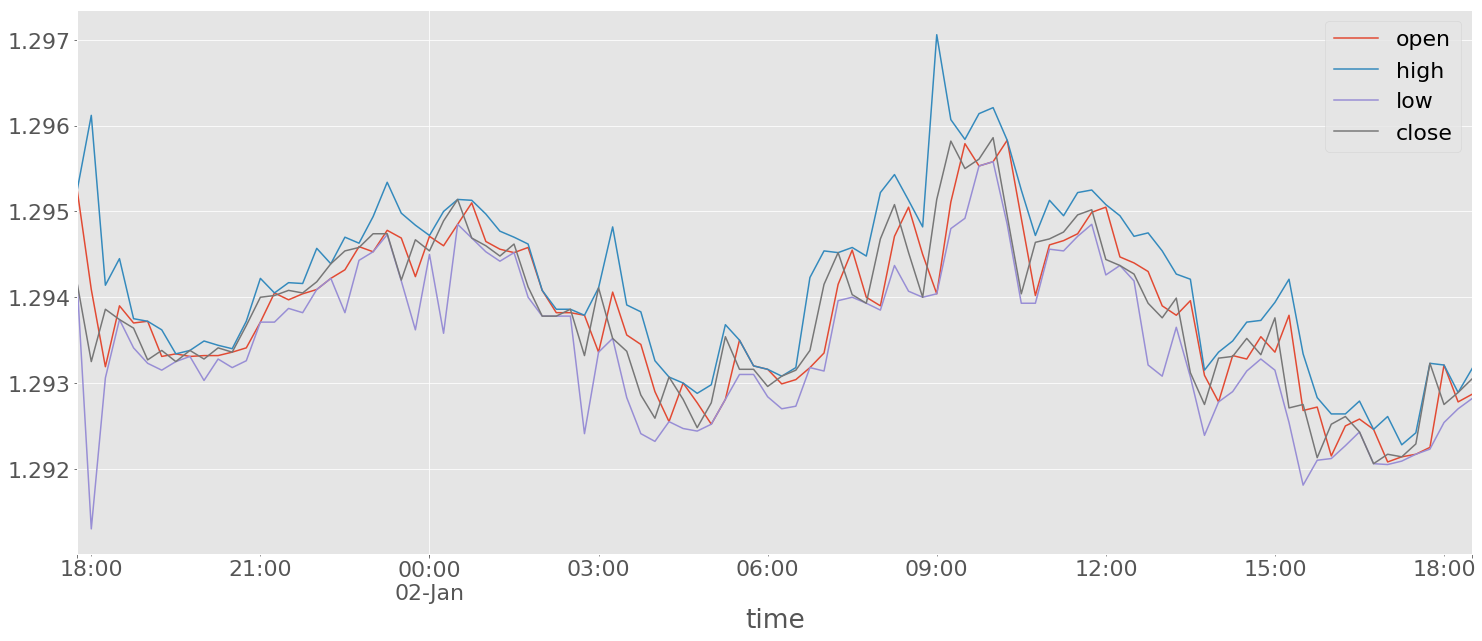

In [78]:
df.iloc[:100].plot(y=['open', 'high', 'low', 'close'], figsize=(25,10))

In [79]:
# for indi in df.columns:
#     df.plot(y=[indi], figsize=(25,10))

In [80]:
# df.iloc[:300].plot(y=['MAC'], figsize=(25,10))

In [81]:
# for col in df.columns:
#     if df[col].isnull().all():
#         print(col)
#         df.drop(col, axis=1, inplace=True)
# df.drop(['ASIN', 'ACOS'],axis=1, inplace=True)

In [82]:
df.shape[0] - df.dropna().shape[0]

134

In [83]:
drop_columns = ['volume', 'close', 'high', 'low', 'open', 'complete', 'log_returns', 'ari_returns', 'log_returns_shifted', 'target_label_direction', 'target_label_direction_shifted']
predict_columns = [i for i in df.columns if i not in drop_columns]
print(predict_columns)
print(len(predict_columns))

['BOP', 'HT_TRENDLINE', 'AD', 'OBV', 'HT_DCPERIOD', 'HT_DCPHASE', 'HT_PHASOR_1', 'HT_PHASOR_2', 'HT_SINE_1', 'HT_SINE_2', 'HT_TRENDMODE', 'TRANGE', 'ADX_5', 'ADX_15', 'ADX_25', 'ADX_35', 'ADX_45', 'ADXR_5', 'ADXR_15', 'ADXR_25', 'ADXR_35', 'ADXR_45', 'AROON_5_1', 'AROON_5_2', 'AROON_15_1', 'AROON_15_2', 'AROON_25_1', 'AROON_25_2', 'AROON_35_1', 'AROON_35_2', 'AROON_45_1', 'AROON_45_2', 'AROONOSC_5', 'AROONOSC_15', 'AROONOSC_25', 'AROONOSC_35', 'AROONOSC_45', 'CCI_5', 'CCI_15', 'CCI_25', 'CCI_35', 'CCI_45', 'CMO_5', 'CMO_15', 'CMO_25', 'CMO_35', 'CMO_45', 'DX_5', 'DX_15', 'DX_25', 'DX_35', 'DX_45', 'MFI_5', 'MFI_15', 'MFI_25', 'MFI_35', 'MFI_45', 'MINUS_DI_5', 'MINUS_DI_15', 'MINUS_DI_25', 'MINUS_DI_35', 'MINUS_DI_45', 'MINUS_DM_5', 'MINUS_DM_15', 'MINUS_DM_25', 'MINUS_DM_35', 'MINUS_DM_45', 'MOM_5', 'MOM_15', 'MOM_25', 'MOM_35', 'MOM_45', 'PLUS_DI_5', 'PLUS_DI_15', 'PLUS_DI_25', 'PLUS_DI_35', 'PLUS_DI_45', 'PLUS_DM_5', 'PLUS_DM_15', 'PLUS_DM_25', 'PLUS_DM_35', 'PLUS_DM_45', 'ROC_5', 'R

In [84]:
df.describe()

,volume,close,high,low,open,log_returns,ari_returns,log_returns_shifted,target_label_direction,target_label_direction_shifted,BOP,HT_TRENDLINE,AD,OBV,HT_DCPERIOD,HT_DCPHASE,HT_PHASOR_1,HT_PHASOR_2,HT_SINE_1,HT_SINE_2,HT_TRENDMODE,TRANGE,ADX_5,ADX_15,ADX_25,ADX_35,ADX_45,ADXR_5,ADXR_15,ADXR_25,ADXR_35,ADXR_45,AROON_5_1,AROON_5_2,AROON_15_1,AROON_15_2,AROON_25_1,AROON_25_2,AROON_35_1,AROON_35_2,AROON_45_1,AROON_45_2,AROONOSC_5,AROONOSC_15,AROONOSC_25,AROONOSC_35,AROONOSC_45,CCI_5,CCI_15,CCI_25,CCI_35,CCI_45,CMO_5,CMO_15,CMO_25,CMO_35,CMO_45,DX_5,DX_15,DX_25,DX_35,DX_45,MFI_5,MFI_15,MFI_25,MFI_35,MFI_45,MINUS_DI_5,MINUS_DI_15,MINUS_DI_25,MINUS_DI_35,MINUS_DI_45,MINUS_DM_5,MINUS_DM_15,MINUS_DM_25,MINUS_DM_35,MINUS_DM_45,MOM_5,MOM_15,MOM_25,MOM_35,MOM_45,PLUS_DI_5,PLUS_DI_15,PLUS_DI_25,PLUS_DI_35,PLUS_DI_45,PLUS_DM_5,PLUS_DM_15,PLUS_DM_25,PLUS_DM_35,PLUS_DM_45,ROC_5,ROC_15,ROC_25,ROC_35,ROC_45,ROCP_5,ROCP_15,ROCP_25,ROCP_35,ROCP_45,ROCR_5,ROCR_15,ROCR_25,ROCR_35,ROCR_45,ROCR100_5,ROCR100_15,ROCR100_25,ROCR100_35,ROCR100_45,RSI_5,RSI_15,RSI_25,RSI_35,RSI_45,TRIX_5,TRIX_15,TRIX_25,TRIX_35,TRIX_45,WILLR_5,WILLR_15,WILLR_25,WILLR_35,WILLR_45,DEMA_5,DEMA_15,DEMA_25,DEMA_35,DEMA_45,EMA_5,EMA_15,EMA_25,EMA_35,EMA_45,KAMA_5,KAMA_15,KAMA_25,KAMA_35,KAMA_45,MIDPOINT_5,MIDPOINT_15,MIDPOINT_25,MIDPOINT_35,MIDPOINT_45,MIDPRICE_5,MIDPRICE_15,MIDPRICE_25,MIDPRICE_35,MIDPRICE_45,SMA_5,SMA_15,SMA_25,SMA_35,SMA_45,TEMA_5,TEMA_15,TEMA_25,TEMA_35,TEMA_45,TRIMA_5,TRIMA_15,TRIMA_25,TRIMA_35,TRIMA_45,WMA_5,WMA_15,WMA_25,WMA_35,WMA_45,ATR_5,ATR_15,ATR_25,ATR_35,ATR_45,NATR_5,NATR_15,NATR_25,NATR_35,NATR_45,BETA_5,BETA_15,BETA_25,BETA_35,BETA_45,CORREL_5,CORREL_15,CORREL_25,CORREL_35,CORREL_45,LINEARREG_5,LINEARREG_15,LINEARREG_25,LINEARREG_35,LINEARREG_45,LINEARREG_ANGLE_5,LINEARREG_ANGLE_15,LINEARREG_ANGLE_25,LINEARREG_ANGLE_35,LINEARREG_ANGLE_45,LINEARREG_INTERCEPT_5,LINEARREG_INTERCEPT_15,LINEARREG_INTERCEPT_25,LINEARREG_INTERCEPT_35,LINEARREG_INTERCEPT_45,LINEARREG_SLOPE_5,LINEARREG_SLOPE_15,LINEARREG_SLOPE_25,LINEARREG_SLOPE_35,LINEARREG_SLOPE_45,TSF_5,TSF_15,TSF_25,TSF_35,TSF_45,APO,MACD_1,MACD_2,MACD_3,MACDEXT_1,MACDEXT_2,MACDEXT_3,MACDFIX_1,MACDFIX_2,MACDFIX_3,PPO,STOCH_1,STOCH_2,STOCHF_1,STOCHF_2,STOCHRSI_1,STOCHRSI_2,ULTOSC,BBANDS_1,BBANDS_2,BBANDS_3,MA,MAMA_1,MAMA_2,SAR,SAREXT,T3,ADOSC,STDDEV,VAR
count,142098.000000,142098.000000,142098.000000,142098.000000,142098.000000,142097.000000,142097.000000,142097.000000,142097.000000,142097.000000,142098.000000,142035.000000,142098.000000,142098.000000,142066.000000,142035.000000,142066.000000,142066.000000,142035.000000,142035.000000,142098.000000,142097.000000,142089.000000,142069.000000,142049.000000,142029.000000,142009.000000,142085.000000,142055.000000,142025.000000,141995.000000,141965.000000,142093.000000,142093.000000,142083.000000,142083.000000,142073.000000,142073.000000,142063.000000,142063.000000,142053.000000,142053.000000,142093.000000,142083.000000,142073.000000,142063.000000,142053.000000,142094.000000,142084.000000,142074.000000,142064.000000,142054.000000,142093.000000,142083.000000,142073.000000,142063.000000,142053.000000,142093.000000,142083.000000,142073.000000,142063.000000,142053.000000,142093.000000,142083.000000,142073.000000,142063.000000,142053.000000,142093.000000,142083.000000,142073.000000,142063.000000,142053.000000,142094.000000,142084.000000,142074.000000,142064.000000,142054.000000,142093.000000,142083.000000,142073.000000,142063.000000,142053.000000,142093.000000,142083.000000,142073.000000,142063.000000,142053.000000,142094.000000,142084.000000,142074.000000,142064.000000,142054.000000,142093.000000,142083.000000,142073.000000,142063.000000,142053.000000,142093.000000,142083.000000,142073.000000,142063.000000,142053.000000,142093.000000,142083.000000,142073.000000,142063.000000,142053.000000,142093.000000,142083.000000,142073.000000,142063.000000,142053.000000,142093.000000,142083.000000,142073.000000,142063.000000,142053.000000,142085.000000,142055.000000,142025.0

In [85]:
df.shape

(142098, 247)

In [86]:
df.dropna(inplace=True)
df.shape

(141964, 247)

In [87]:
y = df['target_label_direction_shifted']
x = df[predict_columns]
print(x.shape, y.shape)
up = sum(y == 1) / len(y) * 100
print('up: {:.2f}%\ndown: {:.2f}%'.format(up, 100-up))

(141964, 237) (141964,)
up: 50.88%
down: 49.12%


In [88]:
ss = StandardScaler()
x_ss = ss.fit_transform(x)
x_ss = pd.DataFrame(x_ss, columns=predict_columns)

In [89]:
x_ss.describe()

,BOP,HT_TRENDLINE,AD,OBV,HT_DCPERIOD,HT_DCPHASE,HT_PHASOR_1,HT_PHASOR_2,HT_SINE_1,HT_SINE_2,HT_TRENDMODE,TRANGE,ADX_5,ADX_15,ADX_25,ADX_35,ADX_45,ADXR_5,ADXR_15,ADXR_25,ADXR_35,ADXR_45,AROON_5_1,AROON_5_2,AROON_15_1,AROON_15_2,AROON_25_1,AROON_25_2,AROON_35_1,AROON_35_2,AROON_45_1,AROON_45_2,AROONOSC_5,AROONOSC_15,AROONOSC_25,AROONOSC_35,AROONOSC_45,CCI_5,CCI_15,CCI_25,CCI_35,CCI_45,CMO_5,CMO_15,CMO_25,CMO_35,CMO_45,DX_5,DX_15,DX_25,DX_35,DX_45,MFI_5,MFI_15,MFI_25,MFI_35,MFI_45,MINUS_DI_5,MINUS_DI_15,MINUS_DI_25,MINUS_DI_35,MINUS_DI_45,MINUS_DM_5,MINUS_DM_15,MINUS_DM_25,MINUS_DM_35,MINUS_DM_45,MOM_5,MOM_15,MOM_25,MOM_35,MOM_45,PLUS_DI_5,PLUS_DI_15,PLUS_DI_25,PLUS_DI_35,PLUS_DI_45,PLUS_DM_5,PLUS_DM_15,PLUS_DM_25,PLUS_DM_35,PLUS_DM_45,ROC_5,ROC_15,ROC_25,ROC_35,ROC_45,ROCP_5,ROCP_15,ROCP_25,ROCP_35,ROCP_45,ROCR_5,ROCR_15,ROCR_25,ROCR_35,ROCR_45,ROCR100_5,ROCR100_15,ROCR100_25,ROCR100_35,ROCR100_45,RSI_5,RSI_15,RSI_25,RSI_35,RSI_45,TRIX_5,TRIX_15,TRIX_25,TRIX_35,TRIX_45,WILLR_5,WILLR_15,WILLR_25,WILLR_35,WILLR_45,DEMA_5,DEMA_15,DEMA_25,DEMA_35,DEMA_45,EMA_5,EMA_15,EMA_25,EMA_35,EMA_45,KAMA_5,KAMA_15,KAMA_25,KAMA_35,KAMA_45,MIDPOINT_5,MIDPOINT_15,MIDPOINT_25,MIDPOINT_35,MIDPOINT_45,MIDPRICE_5,MIDPRICE_15,MIDPRICE_25,MIDPRICE_35,MIDPRICE_45,SMA_5,SMA_15,SMA_25,SMA_35,SMA_45,TEMA_5,TEMA_15,TEMA_25,TEMA_35,TEMA_45,TRIMA_5,TRIMA_15,TRIMA_25,TRIMA_35,TRIMA_45,WMA_5,WMA_15,WMA_25,WMA_35,WMA_45,ATR_5,ATR_15,ATR_25,ATR_35,ATR_45,NATR_5,NATR_15,NATR_25,NATR_35,NATR_45,BETA_5,BETA_15,BETA_25,BETA_35,BETA_45,CORREL_5,CORREL_15,CORREL_25,CORREL_35,CORREL_45,LINEARREG_5,LINEARREG_15,LINEARREG_25,LINEARREG_35,LINEARREG_45,LINEARREG_ANGLE_5,LINEARREG_ANGLE_15,LINEARREG_ANGLE_25,LINEARREG_ANGLE_35,LINEARREG_ANGLE_45,LINEARREG_INTERCEPT_5,LINEARREG_INTERCEPT_15,LINEARREG_INTERCEPT_25,LINEARREG_INTERCEPT_35,LINEARREG_INTERCEPT_45,LINEARREG_SLOPE_5,LINEARREG_SLOPE_15,LINEARREG_SLOPE_25,LINEARREG_SLOPE_35,LINEARREG_SLOPE_45,TSF_5,TSF_15,TSF_25,TSF_35,TSF_45,APO,MACD_1,MACD_2,MACD_3,MACDEXT_1,MACDEXT_2,MACDEXT_3,MACDFIX_1,MACDFIX_2,MACDFIX_3,PPO,STOCH_1,STOCH_2,STOCHF_1,STOCHF_2,STOCHRSI_1,STOCHRSI_2,ULTOSC,BBANDS_1,BBANDS_2,BBANDS_3,MA,MAMA_1,MAMA_2,SAR,SAREXT,T3,ADOSC,STDDEV,VAR
count,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.000000,141964.

In [90]:
pca = PCA(n_components=len(predict_columns))

In [91]:
pca.fit(x_ss)

PCA(copy=True, iterated_power='auto', n_components=237, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

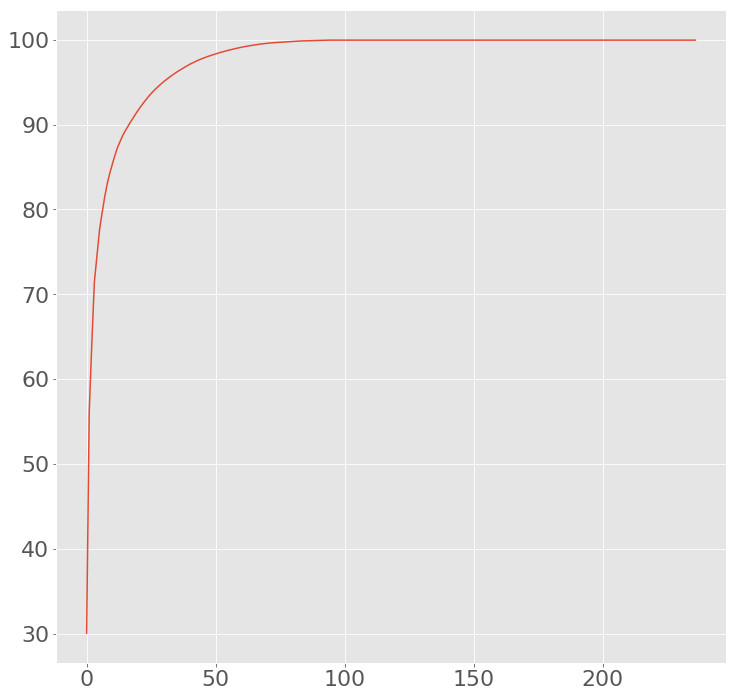

In [92]:
var= pca.explained_variance_ratio_
var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
plt.plot(var1)

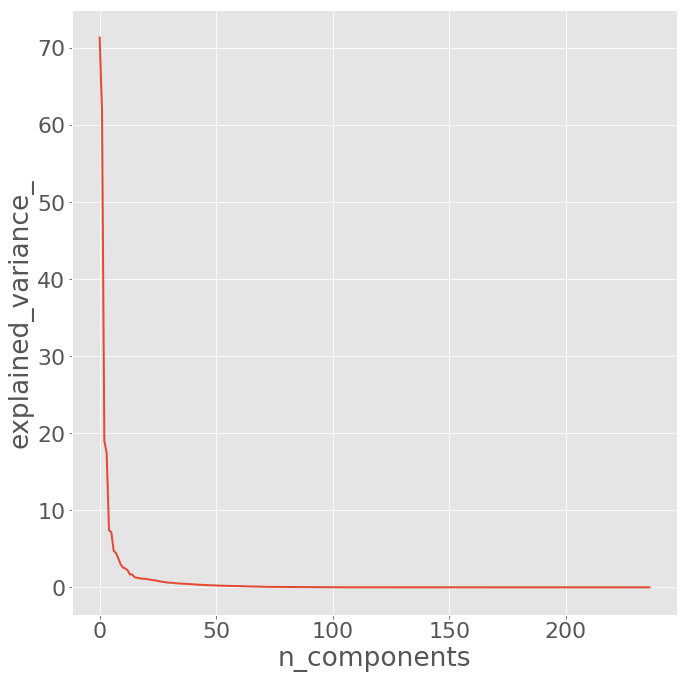

In [93]:
pca = PCA()
pca.fit(x_ss)
plt.figure(1)
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')

In [94]:
pca = PCA(n_components=5)
x_ss_pca =pca.fit_transform(x_ss)
type(x_ss_pca)

numpy.ndarray

In [95]:
print(x_ss_pca.shape)

(141964, 5)


In [96]:
split_index = int(df.shape[0]*.5)
x_train, x_test = x_ss_pca[:split_index], x_ss_pca[split_index:]
y_train, y_test = y[:split_index], y[split_index:]
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)
y_test = pd.Series(y_test.values)

(70982, 5) (70982, 5)
(70982,) (70982,)


In [97]:
# x_train, x_test, y_train, y_test = train_test_split(x, y)
# print(x_train.shape, x_test.shape)
# print(y_train.shape, y_test.shape)

# Model

In [98]:
mom_cols = []
for mom_time in [1, 15, 30, 60, 120]:
    col = 'average_log_return_{}_sign'.format(mom_time)
    df[col] = df['log_returns'].rolling(mom_time).mean().apply(up_down) #the sign of the average returns of the last x candles
    mom_cols.append(col)
print(mom_cols)

['average_log_return_1_sign', 'average_log_return_15_sign', 'average_log_return_30_sign', 'average_log_return_60_sign', 'average_log_return_120_sign']


In [99]:
# sv = make_pipeline(StandardScaler(),SVC())
# lr = make_pipeline(StandardScaler(), LogisticRegression())
# dt = make_pipeline(StandardScaler(), DecisionTreeClassifier())
# rf = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=500))
# ad = make_pipeline(StandardScaler(), AdaBoostClassifier(n_estimators=500))
# gb = make_pipeline(StandardScaler(), GradientBoostingClassifier(n_estimators=500))
# sv = SVC()
lr = LogisticRegression()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier(n_jobs=-1)
ad = AdaBoostClassifier()
gb = GradientBoostingClassifier()
models = [lr, dt, rf, ad, gb]

In [100]:
for mod in models:
    #print(mod.steps[1][1].__class__.__name__)
    print(mod.__class__.__name__)
    print(np.mean(cross_val_score(mod, x_ss_pca, y, cv=3, n_jobs=-1)))

LogisticRegression
0.531169836396
DecisionTreeClassifier
0.501718752346
RandomForestClassifier
0.504994194316
AdaBoostClassifier
0.527126560447
GradientBoostingClassifier
0.527168811435


In [101]:
# sv = make_pipeline(StandardScaler(),SVC())
# lr = make_pipeline(StandardScaler(), LogisticRegression())
# dt = make_pipeline(StandardScaler(), DecisionTreeClassifier())
# rf = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=500))
# ad = make_pipeline(StandardScaler(), AdaBoostClassifier(n_estimators=500))
# gb = make_pipeline(StandardScaler(), GradientBoostingClassifier(n_estimators=500))
# sv = SVC()
lr = LogisticRegression()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier(n_jobs=-1)
ad = AdaBoostClassifier()
gb = GradientBoostingClassifier()
models = [lr, dt, rf, ad, gb]

In [102]:
for mod in models:
    mod.fit(x_train, y_train)

In [103]:
df.head()

,volume,close,high,low,open,log_returns,ari_returns,log_returns_shifted,target_label_direction,target_label_direction_shifted,BOP,HT_TRENDLINE,AD,OBV,HT_DCPERIOD,HT_DCPHASE,HT_PHASOR_1,HT_PHASOR_2,HT_SINE_1,HT_SINE_2,HT_TRENDMODE,TRANGE,ADX_5,ADX_15,ADX_25,ADX_35,ADX_45,ADXR_5,ADXR_15,ADXR_25,ADXR_35,ADXR_45,AROON_5_1,AROON_5_2,AROON_15_1,AROON_15_2,AROON_25_1,AROON_25_2,AROON_35_1,AROON_35_2,AROON_45_1,AROON_45_2,AROONOSC_5,AROONOSC_15,AROONOSC_25,AROONOSC_35,AROONOSC_45,CCI_5,CCI_15,CCI_25,CCI_35,CCI_45,CMO_5,CMO_15,CMO_25,CMO_35,CMO_45,DX_5,DX_15,DX_25,DX_35,DX_45,MFI_5,MFI_15,MFI_25,MFI_35,MFI_45,MINUS_DI_5,MINUS_DI_15,MINUS_DI_25,MINUS_DI_35,MINUS_DI_45,MINUS_DM_5,MINUS_DM_15,MINUS_DM_25,MINUS_DM_35,MINUS_DM_45,MOM_5,MOM_15,MOM_25,MOM_35,MOM_45,PLUS_DI_5,PLUS_DI_15,PLUS_DI_25,PLUS_DI_35,PLUS_DI_45,PLUS_DM_5,PLUS_DM_15,PLUS_DM_25,PLUS_DM_35,PLUS_DM_45,ROC_5,ROC_15,ROC_25,ROC_35,ROC_45,ROCP_5,ROCP_15,ROCP_25,ROCP_35,ROCP_45,ROCR_5,ROCR_15,ROCR_25,ROCR_35,ROCR_45,ROCR100_5,ROCR100_15,ROCR100_25,ROCR100_35,ROCR100_45,RSI_5,RSI_15,RSI_25,RSI_35,RSI_45,TRIX_5,TRIX_15,TRIX_25,TRIX_35,TRIX_45,WILLR_5,WILLR_15,WILLR_25,WILLR_35,WILLR_45,DEMA_5,DEMA_15,DEMA_25,DEMA_35,DEMA_45,EMA_5,EMA_15,EMA_25,EMA_35,EMA_45,KAMA_5,KAMA_15,KAMA_25,KAMA_35,KAMA_45,MIDPOINT_5,MIDPOINT_15,MIDPOINT_25,MIDPOINT_35,MIDPOINT_45,MIDPRICE_5,MIDPRICE_15,MIDPRICE_25,MIDPRICE_35,MIDPRICE_45,SMA_5,SMA_15,SMA_25,SMA_35,SMA_45,TEMA_5,TEMA_15,TEMA_25,TEMA_35,TEMA_45,TRIMA_5,TRIMA_15,TRIMA_25,TRIMA_35,TRIMA_45,WMA_5,WMA_15,WMA_25,WMA_35,WMA_45,ATR_5,ATR_15,ATR_25,ATR_35,ATR_45,NATR_5,NATR_15,NATR_25,NATR_35,NATR_45,BETA_5,BETA_15,BETA_25,BETA_35,BETA_45,CORREL_5,CORREL_15,CORREL_25,CORREL_35,CORREL_45,LINEARREG_5,LINEARREG_15,LINEARREG_25,LINEARREG_35,LINEARREG_45,LINEARREG_ANGLE_5,LINEARREG_ANGLE_15,LINEARREG_ANGLE_25,LINEARREG_ANGLE_35,LINEARREG_ANGLE_45,LINEARREG_INTERCEPT_5,LINEARREG_INTERCEPT_15,LINEARREG_INTERCEPT_25,LINEARREG_INTERCEPT_35,LINEARREG_INTERCEPT_45,LINEARREG_SLOPE_5,LINEARREG_SLOPE_15,LINEARREG_SLOPE_25,LINEARREG_SLOPE_35,LINEARREG_SLOPE_45,TSF_5,TSF_15,TSF_25,TSF_35,TSF_45,APO,MACD_1,MACD_2,MACD_3,MACDEXT_1,MACDEXT_2,MACDEXT_3,MACDFIX_1,MACDFIX_2,MACDFIX_3,PPO,STOCH_1,STOCH_2,STOCHF_1,STOCHF_2,STOCHRSI_1,STOCHRSI_2,ULTOSC,BBANDS_1,BBANDS_2,BBANDS_3,MA,MAMA_1,MAMA_2,SAR,SAREXT,T3,ADOSC,STDDEV,VAR,average_log_return_1_sign,average_log_return_15_sign,average_log_return_30_sign,average_log_return_60_sign,average_log_return_120_sign
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2012-01-03 03:00:00,223,1.297770,1.298130,1.297650,1.297880,-0.000100,-0.000100,-0.000146,0.000000,0.000000,-0.229167,1.294810,-532.256638,1108.000000,28.296828,164.951841,0.001842,0.000416,0.259631,-0.499272,1,0.000480,86.938330,48.279414,26.937698,20.057862,17.364113,86.240539,33.598979,22.388973,20.559953,18.323548,0.000000,20.000000,20.000000,73.333333,0.000000,84.000000,5.714286,88.571429,11.111111,91.111111,20.000000,53.333333,84.000000,82.857143,80.000000,-136.524823,75.734272,109.112298,138.252744,168.752877,28.968645,44.987730,36.727334,29.424186,24.041369,70.930059,71.635075,54.819999,40.682179,29.662754,40.332870,69.464360,72.207427,66.061245,66.968814,5.821923,6.269404,9.818074,12.744058,15.084833,0.000221,0.000621,0.001563,0.002848,0.004364,0.000590,0.003860,0.005030,0.004880,0.005640,34.232668,37.935924,33.643961,30.224676,27.808041,0.001301,0.003760,0.005357,0.006755,0.008045,0.045483,0.298321,0.389096,0.377449,0.436489,0.000455,0.002983,0.003891,0.003774,0.004365,1.000455,1.002983,1.003891,1.003774,1.004365,100.045483,100.298321,100.389096,100.377449,100.436489,64.484323,72.493865,68.363667,64.712093,62.020684,0.021964,0.011445,0.003972,0.001237,0.000225,-65.714286,-21.455224,-18.668831,-17.113095,-16.739447,1.298115,1.298060,1.297278,1.296555,1.295999

In [104]:
print(x_train.shape, y_train.shape)
from keras.utils.np_utils import to_categorical
y_train_binary = to_categorical(y_train)
y_test_binary = to_categorical(y_test)
print(y_train_binary.shape)

(70982, 5) (70982,)
(70982, 2)


In [105]:
# available activation functions at:
# https://keras.io/activations/
# https://en.wikipedia.org/wiki/Activation_function
# options: 'linear', 'sigmoid', 'tanh', 'relu', 'softplus', 'softsign'
# there are other ways to initialize the weights besides 'uniform', too 

model = Sequential()
num_neurons_in_layer = 50
num_inputs = x_train.shape[1]
num_classes = y_train_binary.shape[1]
model.add(Dense(input_dim=num_inputs, 
                 output_dim=num_neurons_in_layer, 
                 init='uniform', 
                 activation='tanh')) 
model.add(Dense(input_dim=num_neurons_in_layer, 
                 output_dim=num_neurons_in_layer, 
                 init='uniform', 
                 activation='tanh'))
model.add(Dense(input_dim=num_neurons_in_layer, 
                 output_dim=num_neurons_in_layer, 
                 init='uniform', 
                 activation='sigmoid'))
model.add(Dense(input_dim=num_neurons_in_layer, 
                 output_dim=num_classes,
                 init='uniform', 
                 activation='softmax')) 
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"] ) # (keep)

/home/applesauce/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=5, activation="tanh", units=50, kernel_initializer="uniform")`
  
/home/applesauce/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=50, activation="tanh", units=50, kernel_initializer="uniform")`
/home/applesauce/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=50, activation="sigmoid", units=50, kernel_initializer="uniform")`
/home/applesauce/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=50, activation="softmax", units=2, kernel_initializer="uniform")`


In [106]:
model.fit(x_train, y_train_binary, epochs=100, batch_size=500, verbose=1,validation_split=0.1)

Train on 63883 samples, validate on 7099 samples
Epoch 1/100
63883/63883 [==============================] - 1s - loss: 0.6907 - acc: 0.5267 - val_loss: 0.6910 - val_acc: 0.5291
Epoch 2/100
63883/63883 [==============================] - 0s - loss: 0.6898 - acc: 0.5355 - val_loss: 0.6904 - val_acc: 0.5299
Epoch 3/100
63883/63883 [==============================] - 0s - loss: 0.6901 - acc: 0.5345 - val_loss: 0.6907 - val_acc: 0.5335
Epoch 4/100
63883/63883 [==============================] - 0s - loss: 0.6900 - acc: 0.5344 - val_loss: 0.6906 - val_acc: 0.5309
Epoch 5/100
63883/63883 [==============================] - 0s - loss: 0.6900 - acc: 0.5362 - val_loss: 0.6909 - val_acc: 0.5302
Epoch 6/100
63883/63883 [==============================] - 0s - loss: 0.6900 - acc: 0.5348 - val_loss: 0.6910 - val_acc: 0.5305
Epoch 7/100
63883/63883 [==============================] - 0s - loss: 0.6897 - acc: 0.5372 - val_loss: 0.6908 - val_acc: 0.5298
Epoch 8/100
63883/63883 [==============================

In [107]:
y_train_pred_nn = model.predict_classes(x_train, verbose=1)
y_test_pred_nn = model.predict_classes(x_test, verbose=1)
y_test_pred_proba_nn = model.predict_proba(x_test)
train_acc = np.sum(y_train == y_train_pred_nn, axis=0) / x_train.shape[0]
test_acc = np.sum(y_test == y_test_pred_nn, axis=0) / x_test.shape[0]
print('\n','train acc: {} test acc: {}'.format(train_acc, test_acc))

70048/70982 [============================>.] - ETA: 0s
 train acc: 0.5398410864726269 test acc: 0.51520103688259


In [108]:
xgb_params = {
    'objective': 'binary:logistic',
    'silent': 1,
    'eval_metric': 'error',
    'max_depth': 3
}

In [109]:
d_train = xgb.DMatrix(x_train, label=y_train)
d_test = xgb.DMatrix(x_test, label=y_test)
watchlist = [(d_train, 'train'), (d_test, 'test')]
clf = xgb.train(xgb_params, d_train, 10000, watchlist, early_stopping_rounds=1000, verbose_eval=10)

[0]	train-error:0.464428	test-error:0.477783
Multiple eval metrics have been passed: 'test-error' will be used for early stopping.

Will train until test-error hasn't improved in 1000 rounds.
[10]	train-error:0.458482	test-error:0.487574
[20]	train-error:0.45482	test-error:0.486602
[30]	train-error:0.451748	test-error:0.482982
[40]	train-error:0.448663	test-error:0.485447
[50]	train-error:0.446212	test-error:0.490082
[60]	train-error:0.442957	test-error:0.496915
[70]	train-error:0.438928	test-error:0.497211
[80]	train-error:0.438506	test-error:0.497027
[90]	train-error:0.435913	test-error:0.496717
[100]	train-error:0.434152	test-error:0.496393
[110]	train-error:0.432208	test-error:0.496746
[120]	train-error:0.428982	test-error:0.496534
[130]	train-error:0.427122	test-error:0.496943
[140]	train-error:0.425784	test-error:0.496605
[150]	train-error:0.424319	test-error:0.496887
[160]	train-error:0.422783	test-error:0.493097
[170]	train-error:0.421064	test-error:0.493308
[180]	train-error:0

In [110]:
xg_predict = clf.predict(d_test)
print(xg_predict.min(), xg_predict.max(), scs.describe(xg_predict))
xg_predict.shape

0.000486541 0.999501 DescribeResult(nobs=70982, minmax=(0.00048654148, 0.99950123), mean=0.42759392, variance=0.044946823, skewness=0.2762356102466583, kurtosis=-0.634139563628342)


(70982,)

In [111]:
predict_df_cols = ['log_returns'] + mom_cols
prediction_df = df[predict_df_cols][split_index:]
print(type(prediction_df))
print(prediction_df.shape)
prediction_df.head(50)

<class 'pandas.core.frame.DataFrame'>
(70982, 6)


,log_returns,average_log_return_1_sign,average_log_return_15_sign,average_log_return_30_sign,average_log_return_60_sign,average_log_return_120_sign
time,,,,,,
2014-10-30 19:45:00,-0.000531,0,0.000000,1.000000,0.000000,0.000000
2014-10-30 20:00:00,0.000381,1,0.000000,1.000000,1.000000,0.000000
2014-10-30 20:15:00,-0.000016,0,0.000000,1.000000,1.000000,0.000000
2014-10-30 20:30:00,0.000111,1,0.000000,1.000000,1.000000,0.000000
2014-10-30 20:45:00,0.000238,1,1.000000,1.000000,1.000000,0.000000
2014-10-30 21:00:00,0.000032,1,0.000000,1.000000,1.000000,0.000000
2014-10-30 21:15:00,0.000159,1,1.000000,1.000000,1.000000,0.000000
2014-10-30 21:30:00,0.000095,1,1.000000,0.000000,1.000000,0.000000
2014-10-30 21:45:00,-0.000301,0,0.000000,0.000000,1.000000,0.000000


In [112]:
prediction_df['nn_prediction'] = y_test_pred_nn

In [113]:
prediction_df['xg_prediction'] = (xg_predict>=.5)*1

In [114]:
prediction_df['always_1'] = 1
prediction_df['always_0'] = 0

In [115]:
prediction_df.head()

,log_returns,average_log_return_1_sign,average_log_return_15_sign,average_log_return_30_sign,average_log_return_60_sign,average_log_return_120_sign,nn_prediction,xg_prediction,always_1,always_0
time,,,,,,,,,,
2014-10-30 19:45:00,-0.000531,0,0.000000,1.000000,0.000000,0.000000,1,1,1,0
2014-10-30 20:00:00,0.000381,1,0.000000,1.000000,1.000000,0.000000,1,1,1,0
2014-10-30 20:15:00,-0.000016,0,0.000000,1.000000,1.000000,0.000000,1,1,1,0
2014-10-30 20:30:00,0.000111,1,0.000000,1.000000,1.000000,0.000000,1,0,1,0
2014-10-30 20:45:00,0.000238,1,1.000000,1.000000,1.000000,0.000000,0,0,1,0


In [116]:
for mod in prediction_df.columns[1:]:
    print(mod)
    y_pred = prediction_df[mod].values
    print('----------------------------')
    print('accuracy', accuracy_score(y_test, y_pred))
    print('----------------------------')
    print('recall', recall_score(y_test, y_pred))
    print('----------------------------')
    print('precision', precision_score(y_test, y_pred))
    print('----------------------------')
    print(pd.crosstab(y_test, y_pred))
    print('----------------------------')
    print(classification_report(y_test, y_pred))
    print('----------------------------')

average_log_return_1_sign
----------------------------
accuracy 0.477726747626
----------------------------
recall 0.48572538357
----------------------------
precision 0.48572538357
----------------------------
col_0         0      1
row_0                 
0.000000  16403  18536
1.000000  18536  17507
----------------------------
             precision    recall  f1-score   support

        0.0       0.47      0.47      0.47     34939
        1.0       0.49      0.49      0.49     36043

avg / total       0.48      0.48      0.48     70982

----------------------------
average_log_return_15_sign
----------------------------
accuracy 0.483207010228
----------------------------
recall 0.481591432456
----------------------------
precision 0.490949202398
----------------------------
col_0     0.000000  1.000000
row_0                       
0.000000     16941     17998
1.000000     18685     17358
----------------------------
             precision    recall  f1-score   support

        0.0

/home/applesauce/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/applesauce/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [117]:
for mod in models:
    #mod_name = mod.steps[1][1].__class__.__name__
    mod_name = mod.__class__.__name__
    print(mod_name)
    print('----------------------------')
    print('accuracy', mod.score(x_test, y_test))
    print('----------------------------')
    y_pred = mod.predict(x_test)
    prediction_df[mod_name] = y_pred
    y_pred = pd.Series(y_pred, name='pred')
    print('recall', recall_score(y_test, y_pred))
    print('----------------------------')
    print('precision', precision_score(y_test, y_pred))
    print('----------------------------')
    print(pd.crosstab(y_test, y_pred))
    print('----------------------------')
    print(classification_report(y_test, y_pred))
    print('----------------------------')

LogisticRegression
----------------------------
accuracy 0.526471499817
----------------------------
recall 0.639513913936
----------------------------
precision 0.527834390529
----------------------------
pred      0.000000  1.000000
row_0                       
0.000000     14320     20619
1.000000     12993     23050
----------------------------
             precision    recall  f1-score   support

        0.0       0.52      0.41      0.46     34939
        1.0       0.53      0.64      0.58     36043

avg / total       0.53      0.53      0.52     70982

----------------------------
DecisionTreeClassifier
----------------------------
accuracy 0.494054830802
----------------------------
recall 0.537163943068
----------------------------
precision 0.501684286899
----------------------------
pred      0.000000  1.000000
row_0                       
0.000000     15708     19231
1.000000     16682     19361
----------------------------
             precision    recall  f1-score   suppo

LogisticRegression 0.533941352383
DecisionTreeClassifier 0.493373751493
RandomForestClassifier 0.504942187313
AdaBoostClassifier 0.527825987496
GradientBoostingClassifier 0.510959047974


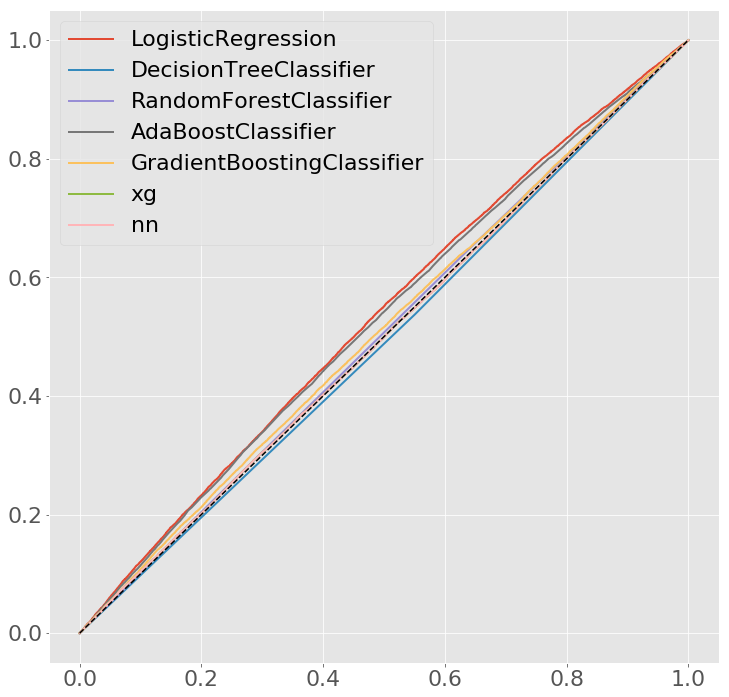

In [118]:
for classer in models:
    probas = classer.predict_proba(x_test)
    fpr, tpr, thresholds = roc_curve(y_test, probas[:, 1])
    roc_auc = auc(fpr, tpr)
    classer_name = classer.__class__.__name__
    #classer_name = classer.steps[1][1].__class__.__name__
    print(classer_name, roc_auc)
    plt.plot(fpr, tpr, lw=2, label=classer_name)
fpr, tpr, thresholds = roc_curve(y_test, xg_predict)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, label='xg')
fpr, tpr, thresholds = roc_curve(y_test, xg_predict)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, label='nn')
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc='best')

In [119]:
for classer in models[1:]:
    feat_impor = classer.feature_importances_
    x_feat = pd.DataFrame({'cols': [str(i) for i in range(x_ss_pca.shape[1])], 'feat_impo': feat_impor})
    classer_name = classer.__class__.__name__
    print(classer_name, '\n', x_feat.sort_values(by='feat_impo', ascending=False))

DecisionTreeClassifier 
   cols  feat_impo
2    2   0.206261
4    4   0.202454
1    1   0.199163
0    0   0.198453
3    3   0.193668
RandomForestClassifier 
   cols  feat_impo
2    2   0.202993
1    1   0.200634
3    3   0.199628
0    0   0.198619
4    4   0.198126
AdaBoostClassifier 
   cols  feat_impo
4    4   0.320000
1    1   0.240000
2    2   0.160000
3    3   0.160000
0    0   0.120000
GradientBoostingClassifier 
   cols  feat_impo
3    3   0.232242
2    2   0.226748
1    1   0.222597
4    4   0.190477
0    0   0.127935


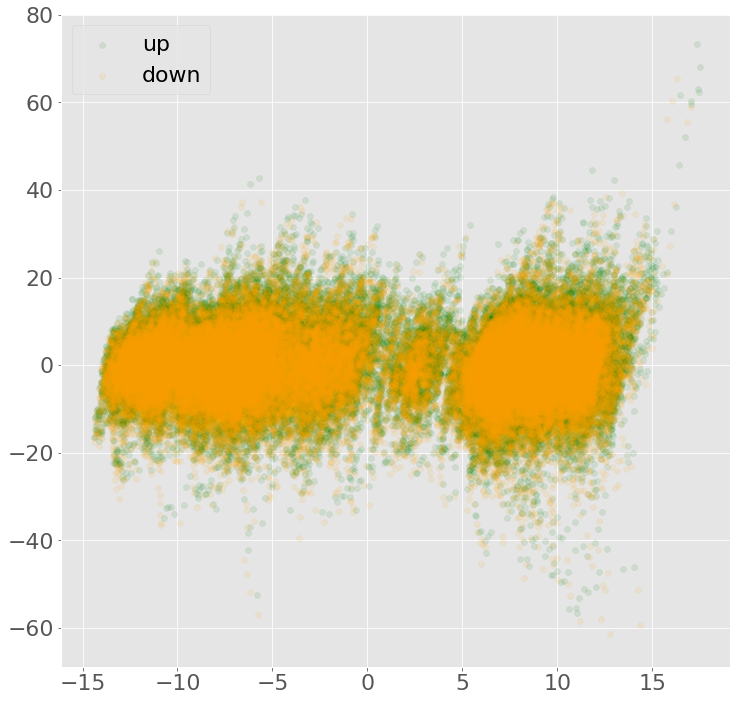

In [120]:
pca = PCA(n_components=2)
x_new = pca.fit_transform(x_ss_pca)
fig, ax = plt.subplots()
x_new_one = x_new[y==1]
x_new_zero = x_new[y==0]
ax.scatter(x_new_one[:,0], x_new_one[:,1], c='green', label='up', alpha=.1)
ax.scatter(x_new_zero[:,0], x_new_zero[:,1], c='orange', label='down', alpha=.1)
plt.legend(loc='best')

In [121]:
model_list = list(prediction_df.columns[1:])
for mod_col in model_list:
    prediction_df[mod_col] = prediction_df[mod_col].map({1:1, 0:-1}).shift(1)

In [122]:
prediction_df.head()

,log_returns,average_log_return_1_sign,average_log_return_15_sign,average_log_return_30_sign,average_log_return_60_sign,average_log_return_120_sign,nn_prediction,xg_prediction,always_1,always_0,LogisticRegression,DecisionTreeClassifier,RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
time,,,,,,,,,,,,,,,
2014-10-30 19:45:00,-0.000531,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2014-10-30 20:00:00,0.000381,-1.000000,-1.000000,1.000000,-1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000
2014-10-30 20:15:00,-0.000016,1.000000,-1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,-1.000000,-1.000000,1.000000,1.000000
2014-10-30 20:30:00,0.000111,-1.000000,-1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000
2014-10-30 20:45:00,0.000238,1.000000,-1.000000,1.000000,1.000000,-1.000000,1.000000,-1.000000,1.000000,-1.000000,1.000000,1.000000,-1.000000,-1.000000,1.000000


In [123]:
model_returns = ['log_returns']
for mod_col in model_list:
    model_returns.append(mod_col+'_returns')
    prediction_df[mod_col+'_returns'] = prediction_df[mod_col] * prediction_df['log_returns']

In [124]:
prediction_df.head()

,log_returns,average_log_return_1_sign,average_log_return_15_sign,average_log_return_30_sign,average_log_return_60_sign,average_log_return_120_sign,nn_prediction,xg_prediction,always_1,always_0,LogisticRegression,DecisionTreeClassifier,RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier,average_log_return_1_sign_returns,average_log_return_15_sign_returns,average_log_return_30_sign_returns,average_log_return_60_sign_returns,average_log_return_120_sign_returns,nn_prediction_returns,xg_prediction_returns,always_1_returns,always_0_returns,LogisticRegression_returns,DecisionTreeClassifier_returns,RandomForestClassifier_returns,AdaBoostClassifier_returns,GradientBoostingClassifier_returns
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-10-30 19:45:00,-0.000531,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2014-10-30 20:00:00,0.000381,-1.000000,-1.000000,1.000000,-1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,-0.000381,-0.000381,0.000381,-0.000381,-0.000381,0.000381,0.000381,0.000381,-0.000381,0.000381,0.000381,-0.000381,0.000381,0.000381
2014-10-30 20:15:00,-0.000016,1.000000,-1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,-1.000000,-1.000000,1.000000,1.000000,-0.000016,0.000016,-0.000016,-0.000016,0.000016,-0.000016,-0.000016,-0.000016,0.000016,-0.000016,0.000016,0.000016,-0.000016,-0.000016
2014-10-30 20:30:00,0.000111,-1.000000,-1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,-0.000111,-0.000111,0.000111,0.000111,-0.000111,0.000111,0.000111,0.000111,-0.000111,0.000111,0.000111,-0.000111,0.000111,0.000111
2014-10-30 20:45:00,0.000238,1.000000,-1.000000,1.000000,1.000000,-1.000000,1.000000,-1.000000,1.000000,-1.000000,1.000000,1.000000,-1.000000,-1.000000,1.000000,0.000238,-0.000238,0.000238,0.000238,-0.000238,0.000238,-0.000238,0.000238,-0.000238,0.000238,0.000238,-0.000238,-0.000238,0.000238


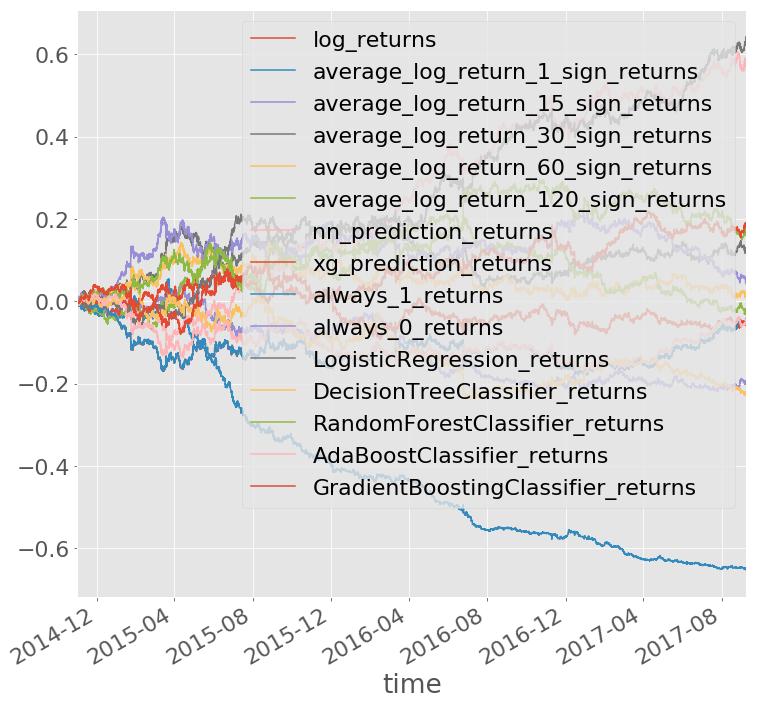

In [125]:
fig, axes = plt.subplots()
cum_returns = prediction_df[model_returns].cumsum().apply(np.exp)-1 #you can add log returns and then transpose back with np.exp
cum_returns.plot(ax=axes)
plt.legend(loc='best')

In [126]:
df.head(20)

,volume,close,high,low,open,log_returns,ari_returns,log_returns_shifted,target_label_direction,target_label_direction_shifted,BOP,HT_TRENDLINE,AD,OBV,HT_DCPERIOD,HT_DCPHASE,HT_PHASOR_1,HT_PHASOR_2,HT_SINE_1,HT_SINE_2,HT_TRENDMODE,TRANGE,ADX_5,ADX_15,ADX_25,ADX_35,ADX_45,ADXR_5,ADXR_15,ADXR_25,ADXR_35,ADXR_45,AROON_5_1,AROON_5_2,AROON_15_1,AROON_15_2,AROON_25_1,AROON_25_2,AROON_35_1,AROON_35_2,AROON_45_1,AROON_45_2,AROONOSC_5,AROONOSC_15,AROONOSC_25,AROONOSC_35,AROONOSC_45,CCI_5,CCI_15,CCI_25,CCI_35,CCI_45,CMO_5,CMO_15,CMO_25,CMO_35,CMO_45,DX_5,DX_15,DX_25,DX_35,DX_45,MFI_5,MFI_15,MFI_25,MFI_35,MFI_45,MINUS_DI_5,MINUS_DI_15,MINUS_DI_25,MINUS_DI_35,MINUS_DI_45,MINUS_DM_5,MINUS_DM_15,MINUS_DM_25,MINUS_DM_35,MINUS_DM_45,MOM_5,MOM_15,MOM_25,MOM_35,MOM_45,PLUS_DI_5,PLUS_DI_15,PLUS_DI_25,PLUS_DI_35,PLUS_DI_45,PLUS_DM_5,PLUS_DM_15,PLUS_DM_25,PLUS_DM_35,PLUS_DM_45,ROC_5,ROC_15,ROC_25,ROC_35,ROC_45,ROCP_5,ROCP_15,ROCP_25,ROCP_35,ROCP_45,ROCR_5,ROCR_15,ROCR_25,ROCR_35,ROCR_45,ROCR100_5,ROCR100_15,ROCR100_25,ROCR100_35,ROCR100_45,RSI_5,RSI_15,RSI_25,RSI_35,RSI_45,TRIX_5,TRIX_15,TRIX_25,TRIX_35,TRIX_45,WILLR_5,WILLR_15,WILLR_25,WILLR_35,WILLR_45,DEMA_5,DEMA_15,DEMA_25,DEMA_35,DEMA_45,EMA_5,EMA_15,EMA_25,EMA_35,EMA_45,KAMA_5,KAMA_15,KAMA_25,KAMA_35,KAMA_45,MIDPOINT_5,MIDPOINT_15,MIDPOINT_25,MIDPOINT_35,MIDPOINT_45,MIDPRICE_5,MIDPRICE_15,MIDPRICE_25,MIDPRICE_35,MIDPRICE_45,SMA_5,SMA_15,SMA_25,SMA_35,SMA_45,TEMA_5,TEMA_15,TEMA_25,TEMA_35,TEMA_45,TRIMA_5,TRIMA_15,TRIMA_25,TRIMA_35,TRIMA_45,WMA_5,WMA_15,WMA_25,WMA_35,WMA_45,ATR_5,ATR_15,ATR_25,ATR_35,ATR_45,NATR_5,NATR_15,NATR_25,NATR_35,NATR_45,BETA_5,BETA_15,BETA_25,BETA_35,BETA_45,CORREL_5,CORREL_15,CORREL_25,CORREL_35,CORREL_45,LINEARREG_5,LINEARREG_15,LINEARREG_25,LINEARREG_35,LINEARREG_45,LINEARREG_ANGLE_5,LINEARREG_ANGLE_15,LINEARREG_ANGLE_25,LINEARREG_ANGLE_35,LINEARREG_ANGLE_45,LINEARREG_INTERCEPT_5,LINEARREG_INTERCEPT_15,LINEARREG_INTERCEPT_25,LINEARREG_INTERCEPT_35,LINEARREG_INTERCEPT_45,LINEARREG_SLOPE_5,LINEARREG_SLOPE_15,LINEARREG_SLOPE_25,LINEARREG_SLOPE_35,LINEARREG_SLOPE_45,TSF_5,TSF_15,TSF_25,TSF_35,TSF_45,APO,MACD_1,MACD_2,MACD_3,MACDEXT_1,MACDEXT_2,MACDEXT_3,MACDFIX_1,MACDFIX_2,MACDFIX_3,PPO,STOCH_1,STOCH_2,STOCHF_1,STOCHF_2,STOCHRSI_1,STOCHRSI_2,ULTOSC,BBANDS_1,BBANDS_2,BBANDS_3,MA,MAMA_1,MAMA_2,SAR,SAREXT,T3,ADOSC,STDDEV,VAR,average_log_return_1_sign,average_log_return_15_sign,average_log_return_30_sign,average_log_return_60_sign,average_log_return_120_sign
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2012-01-03 03:00:00,223,1.297770,1.298130,1.297650,1.297880,-0.000100,-0.000100,-0.000146,0.000000,0.000000,-0.229167,1.294810,-532.256638,1108.000000,28.296828,164.951841,0.001842,0.000416,0.259631,-0.499272,1,0.000480,86.938330,48.279414,26.937698,20.057862,17.364113,86.240539,33.598979,22.388973,20.559953,18.323548,0.000000,20.000000,20.000000,73.333333,0.000000,84.000000,5.714286,88.571429,11.111111,91.111111,20.000000,53.333333,84.000000,82.857143,80.000000,-136.524823,75.734272,109.112298,138.252744,168.752877,28.968645,44.987730,36.727334,29.424186,24.041369,70.930059,71.635075,54.819999,40.682179,29.662754,40.332870,69.464360,72.207427,66.061245,66.968814,5.821923,6.269404,9.818074,12.744058,15.084833,0.000221,0.000621,0.001563,0.002848,0.004364,0.000590,0.003860,0.005030,0.004880,0.005640,34.232668,37.935924,33.643961,30.224676,27.808041,0.001301,0.003760,0.005357,0.006755,0.008045,0.045483,0.298321,0.389096,0.377449,0.436489,0.000455,0.002983,0.003891,0.003774,0.004365,1.000455,1.002983,1.003891,1.003774,1.004365,100.045483,100.298321,100.389096,100.377449,100.436489,64.484323,72.493865,68.363667,64.712093,62.020684,0.021964,0.011445,0.003972,0.001237,0.000225,-65.714286,-21.455224,-18.668831,-17.113095,-16.739447,1.298115,1.298060,1.297278,1.296555,1.295999

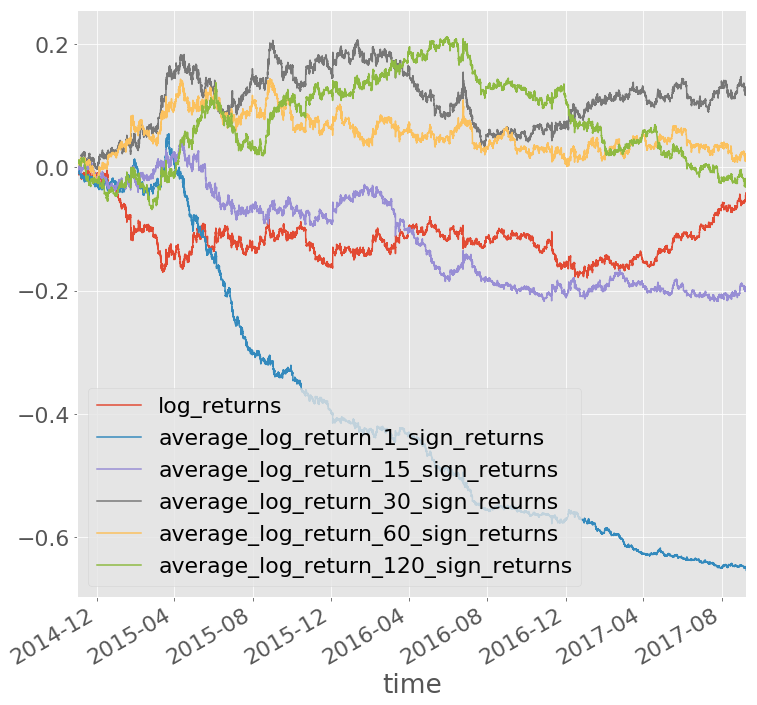

In [127]:
fig, axes = plt.subplots()
cum_returns = prediction_df[model_returns[:6]].cumsum().apply(np.exp)-1 #you can add log returns and then transpose back with np.exp
cum_returns.plot(ax=axes)
plt.legend(loc='best')

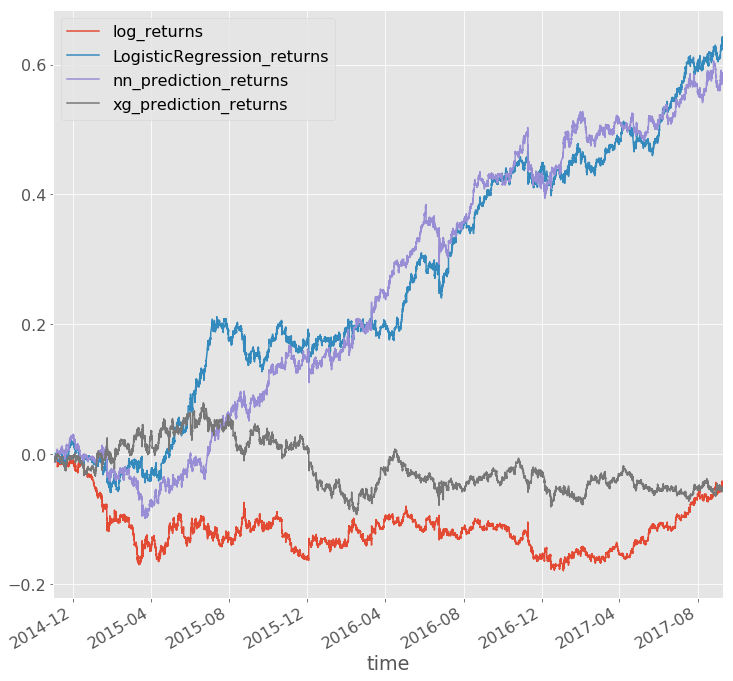

In [128]:
plt.rcParams.update({'font.size': 16})
fig, axes = plt.subplots()
cum_returns = prediction_df[[model_returns[0]]+[model_returns[10]]+model_returns[6:8]].cumsum().apply(np.exp)-1 #you can add log returns and then transpose back with np.exp
cum_returns.plot(ax=axes)
plt.legend(loc='best')

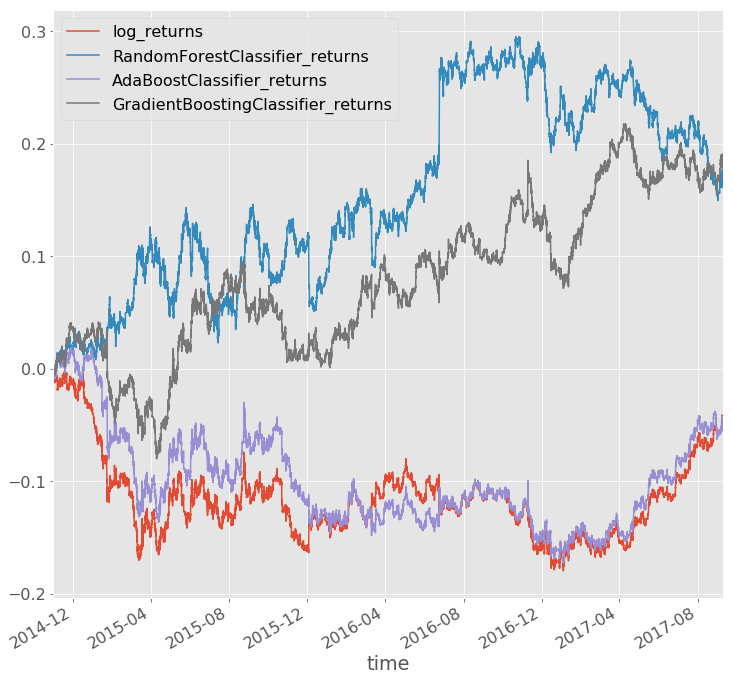

In [129]:
plt.rcParams.update({'font.size': 16})
fig, axes = plt.subplots()
cum_returns = prediction_df[[model_returns[0]]+model_returns[12:]].cumsum().apply(np.exp)-1 #you can add log returns and then transpose back with np.exp
cum_returns.plot(ax=axes)
plt.legend(loc='best')